# Linguistic Similarity of Major vs. Minor Characters in Homer's Epics

## Research Question

**Claim**: Major speaking characters in the Iliad (Achilles, Hector, Agamemnon, etc.) exhibit greater linguistic similarity to each other than minor characters. The same methodology should generalize to the Odyssey.

---

## Project Overview

This notebook performs a comprehensive NLP analysis to test whether major characters in Homer's Iliad and Odyssey exhibit distinctive linguistic patterns compared to minor characters. We analyze:

1. **Lexical patterns**: Vocabulary usage, distinctive words, bigrams/trigrams
2. **Syntactic patterns**: Part-of-Speech distributions and grammatical structures
3. **Semantic similarity**: Embedding-based topic and thematic analysis
4. **Stylometric features**: Sentence length, function word usage, speech patterns

We test three hypotheses:
- **H1**: Major characters' speech is more similar *within* the major group than minor characters' speech is within the minor group
- **H2**: Major characters cluster together distinctly from minor characters in linguistic feature space
- **H3**: Characters cluster by their narrative roles (hero, god, helper, antagonist)

---

## Methodology Summary

| Analysis Type | Method | Tools |
|--------------|--------|-------|
| Speech Extraction | Regex-based dialogue attribution | Python re |
| Character Classification | Speaking frequency + volume | pandas |
| Lexical Similarity | TF-IDF, Jaccard, n-grams | sklearn, NLTK |
| Syntactic Similarity | POS tag distributions | spaCy |
| Semantic Similarity | Sentence embeddings | sentence-transformers |
| Stylometric Analysis | Statistical features | numpy, scipy |
| Clustering | Hierarchical, K-means, UMAP | sklearn, umap-learn |

---

**Author**: NLP Final Project  
**Data**: Homer's Iliad and Odyssey (Butler translation, Project Gutenberg)


## 1. Setup and Configuration

### 1.1 Import Libraries

We use standard NLP libraries for text processing, analysis, and visualization. All dependencies are listed in `requirements.txt`.


In [1]:
# ============================================================================
# IMPORTS AND CONFIGURATION
# ============================================================================

import re
import os
import json
import warnings
from pathlib import Path
from collections import Counter, defaultdict
from typing import Dict, List, Tuple, Any, Optional, Set
from itertools import combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Libraries
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr, spearmanr

# Sentence Transformers for embeddings
from sentence_transformers import SentenceTransformer

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Create results directories
RESULTS_DIR = Path("../results")
FIGURES_DIR = RESULTS_DIR / "figures"
TABLES_DIR = RESULTS_DIR / "tables"
DATA_DIR = Path("../data")

for d in [RESULTS_DIR, FIGURES_DIR, TABLES_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("✓ All libraries imported successfully")
print(f"✓ Results will be saved to: {RESULTS_DIR.resolve()}")


✓ All libraries imported successfully
✓ Results will be saved to: C:\Users\lucca\Documents\GitHub\NLP-Final-Project\results


### 1.2 Character Metadata

We define comprehensive character metadata for both epics. This includes:
- **Name variants**: Different ways characters are referred to (name, epithets, translation variants)
- **Narrative roles**: Hero, god, helper, antagonist, etc.
- **Role categories**: For clustering analysis by function in the narrative

These lists are based on scholarly consensus and have been fact-checked for consistency.


In [2]:
# ============================================================================
# CHARACTER METADATA FOR BOTH EPICS
# ============================================================================

# Iliad Characters with roles and name variants (Butler translation)
ILIAD_CHARACTERS = {
    # Greeks (Achaeans)
    "Achilles": {
        "patterns": [r"\bachilles\b", r"\bson of peleus\b", r"\bpelides\b", r"\baeacides\b"],
        "role": "hero",
        "role_detail": "hero / primary fighter",
        "faction": "greek"
    },
    "Agamemnon": {
        "patterns": [r"\bagamemnon\b", r"\bson of atreus\b", r"\batrides\b", r"\batreides\b"],
        "role": "king",
        "role_detail": "king / commander",
        "faction": "greek"
    },
    "Menelaus": {
        "patterns": [r"\bmenelaus\b", r"\bson of atreus\b"],
        "role": "king",
        "role_detail": "king / fighter",
        "faction": "greek"
    },
    "Odysseus": {
        "patterns": [r"\bodysseus\b", r"\bulysses\b", r"\bson of laertes\b", r"\blaertiades\b"],
        "role": "hero",
        "role_detail": "hero / strategist",
        "faction": "greek"
    },
    "Ajax the Greater": {
        "patterns": [r"\bajax son of telamon\b", r"\btelamonian ajax\b", r"\bajax\b"],
        "role": "fighter",
        "role_detail": "fighter",
        "faction": "greek"
    },
    "Diomedes": {
        "patterns": [r"\bdiomedes\b", r"\bdiomed\b", r"\bson of tydeus\b", r"\btydides\b"],
        "role": "hero",
        "role_detail": "hero / fighter",
        "faction": "greek"
    },
    "Nestor": {
        "patterns": [r"\bnestor\b", r"\bson of neleus\b"],
        "role": "advisor",
        "role_detail": "king / advisor",
        "faction": "greek"
    },
    "Patroclus": {
        "patterns": [r"\bpatroclus\b", r"\bson of menoetius\b"],
        "role": "helper",
        "role_detail": "helper / fighter",
        "faction": "greek"
    },
    "Calchas": {
        "patterns": [r"\bcalchas\b"],
        "role": "prophet",
        "role_detail": "prophet",
        "faction": "greek"
    },
    "Thersites": {
        "patterns": [r"\bthersites\b"],
        "role": "minor",
        "role_detail": "soldier (comic role)",
        "faction": "greek"
    },
    # Trojans
    "Hector": {
        "patterns": [r"\bhector\b", r"\bson of priam\b"],
        "role": "hero",
        "role_detail": "hero / defender",
        "faction": "trojan"
    },
    "Paris": {
        "patterns": [r"\bparis\b", r"\balexander\b", r"\balexandrus\b"],
        "role": "fighter",
        "role_detail": "prince / fighter",
        "faction": "trojan"
    },
    "Priam": {
        "patterns": [r"\bpriam\b", r"\bson of laomedon\b"],
        "role": "king",
        "role_detail": "king",
        "faction": "trojan"
    },
    "Hecuba": {
        "patterns": [r"\bhecuba\b"],
        "role": "queen",
        "role_detail": "queen",
        "faction": "trojan"
    },
    "Andromache": {
        "patterns": [r"\bandromache\b"],
        "role": "helper",
        "role_detail": "helper",
        "faction": "trojan"
    },
    "Helen": {
        "patterns": [r"\bhelen\b", r"\bdaughter of jove\b"],
        "role": "queen",
        "role_detail": "queen / cause of war",
        "faction": "trojan"
    },
    "Aeneas": {
        "patterns": [r"\baeneas\b", r"\bson of anchises\b"],
        "role": "hero",
        "role_detail": "hero / fighter",
        "faction": "trojan"
    },
    "Briseis": {
        "patterns": [r"\bbriseis\b"],
        "role": "captive",
        "role_detail": "captive",
        "faction": "captive"
    },
    "Chryseis": {
        "patterns": [r"\bchryseis\b"],
        "role": "captive",
        "role_detail": "captive",
        "faction": "captive"
    },
    # Gods
    "Zeus": {
        "patterns": [r"\bzeus\b", r"\bjove\b", r"\bson of saturn\b", r"\bfather of gods\b"],
        "role": "god",
        "role_detail": "god",
        "faction": "olympian"
    },
    "Hera": {
        "patterns": [r"\bhera\b", r"\bjuno\b", r"\bdaughter of saturn\b"],
        "role": "god",
        "role_detail": "goddess / helper",
        "faction": "olympian"
    },
    "Athena": {
        "patterns": [r"\bathena\b", r"\bminerva\b", r"\bpallas\b"],
        "role": "god",
        "role_detail": "goddess / helper",
        "faction": "olympian"
    },
    "Apollo": {
        "patterns": [r"\bapollo\b", r"\bphoebus\b", r"\bson of jove and leto\b"],
        "role": "god",
        "role_detail": "god / helper",
        "faction": "olympian"
    },
    "Ares": {
        "patterns": [r"\bares\b", r"\bmars\b"],
        "role": "god",
        "role_detail": "god / fighter",
        "faction": "olympian"
    },
    "Aphrodite": {
        "patterns": [r"\baphrodite\b", r"\bvenus\b", r"\bcyprian goddess\b"],
        "role": "god",
        "role_detail": "goddess / helper",
        "faction": "olympian"
    },
    "Poseidon": {
        "patterns": [r"\bposeidon\b", r"\bneptune\b", r"\bearthshaker\b"],
        "role": "god",
        "role_detail": "god / helper",
        "faction": "olympian"
    },
    "Thetis": {
        "patterns": [r"\bthetis\b", r"\bsilver-footed\b"],
        "role": "god",
        "role_detail": "goddess / helper",
        "faction": "olympian"
    },
    "Hermes": {
        "patterns": [r"\bhermes\b", r"\bmercury\b", r"\bargus-slayer\b"],
        "role": "god",
        "role_detail": "god / helper",
        "faction": "olympian"
    },
    "Hephaestus": {
        "patterns": [r"\bhephaestus\b", r"\bvulcan\b"],
        "role": "god",
        "role_detail": "god / helper",
        "faction": "olympian"
    },
    "Iris": {
        "patterns": [r"\biris\b"],
        "role": "god",
        "role_detail": "goddess / messenger",
        "faction": "olympian"
    },
    "Sleep": {
        "patterns": [r"\bsleep\b"],
        "role": "minor_deity",
        "role_detail": "minor deity",
        "faction": "olympian"
    },
    "Death": {
        "patterns": [r"\bdeath\b"],
        "role": "minor_deity",
        "role_detail": "minor deity",
        "faction": "olympian"
    },
}

# Odyssey Characters with roles and name variants
ODYSSEY_CHARACTERS = {
    # Main characters
    "Odysseus": {
        "patterns": [r"\bodysseus\b", r"\bulysses\b", r"\bson of laertes\b", r"\blaertiades\b"],
        "role": "hero",
        "role_detail": "hero",
        "faction": "ithacan"
    },
    "Telemachus": {
        "patterns": [r"\btelemachus\b", r"\bson of odysseus\b"],
        "role": "helper",
        "role_detail": "helper / emerging hero",
        "faction": "ithacan"
    },
    "Penelope": {
        "patterns": [r"\bpenelope\b", r"\bdaughter of icarius\b"],
        "role": "helper",
        "role_detail": "helper",
        "faction": "ithacan"
    },
    "Eumaeus": {
        "patterns": [r"\beumaeus\b", r"\bswineherd\b"],
        "role": "helper",
        "role_detail": "loyal helper",
        "faction": "ithacan"
    },
    "Philoetius": {
        "patterns": [r"\bphiloetius\b"],
        "role": "helper",
        "role_detail": "helper",
        "faction": "ithacan"
    },
    "Eurycleia": {
        "patterns": [r"\beurycleia\b"],
        "role": "helper",
        "role_detail": "helper",
        "faction": "ithacan"
    },
    "Laertes": {
        "patterns": [r"\blaertes\b"],
        "role": "helper",
        "role_detail": "retired king / helper",
        "faction": "ithacan"
    },
    # Suitors (Antagonists)
    "Antinous": {
        "patterns": [r"\bantinous\b"],
        "role": "antagonist",
        "role_detail": "main suitor / antagonist",
        "faction": "suitor"
    },
    "Eurymachus": {
        "patterns": [r"\beurymachus\b"],
        "role": "antagonist",
        "role_detail": "suitor / antagonist",
        "faction": "suitor"
    },
    # Gods
    "Athena": {
        "patterns": [r"\bathena\b", r"\bminerva\b", r"\bpallas\b"],
        "role": "god",
        "role_detail": "goddess / helper",
        "faction": "olympian"
    },
    "Zeus": {
        "patterns": [r"\bzeus\b", r"\bjove\b", r"\bson of saturn\b"],
        "role": "god",
        "role_detail": "god",
        "faction": "olympian"
    },
    "Poseidon": {
        "patterns": [r"\bposeidon\b", r"\bneptune\b"],
        "role": "god",
        "role_detail": "god / antagonist",
        "faction": "olympian"
    },
    "Hermes": {
        "patterns": [r"\bhermes\b", r"\bmercury\b"],
        "role": "god",
        "role_detail": "god / helper",
        "faction": "olympian"
    },
    # Magical beings / Helpers
    "Circe": {
        "patterns": [r"\bcirce\b"],
        "role": "helper",
        "role_detail": "goddess / witch / helper",
        "faction": "magical"
    },
    "Calypso": {
        "patterns": [r"\bcalypso\b"],
        "role": "helper",
        "role_detail": "goddess / helper",
        "faction": "magical"
    },
    # Antagonists / Monsters
    "Polyphemus": {
        "patterns": [r"\bpolyphemus\b", r"\bcyclops\b"],
        "role": "antagonist",
        "role_detail": "cyclops / antagonist",
        "faction": "monster"
    },
    "Melanthius": {
        "patterns": [r"\bmelanthius\b"],
        "role": "antagonist",
        "role_detail": "antagonist",
        "faction": "ithacan"
    },
    "Melantho": {
        "patterns": [r"\bmelantho\b"],
        "role": "antagonist",
        "role_detail": "antagonist",
        "faction": "ithacan"
    },
    # Phaeacians
    "Nausicaa": {
        "patterns": [r"\bnausicaa\b"],
        "role": "helper",
        "role_detail": "helper",
        "faction": "phaeacian"
    },
    "Alcinous": {
        "patterns": [r"\balcinous\b"],
        "role": "helper",
        "role_detail": "king / helper",
        "faction": "phaeacian"
    },
    "Arete": {
        "patterns": [r"\barete\b"],
        "role": "helper",
        "role_detail": "queen / helper",
        "faction": "phaeacian"
    },
    # Shades (Underworld)
    "Tiresias": {
        "patterns": [r"\btiresias\b"],
        "role": "prophet",
        "role_detail": "prophet",
        "faction": "shade"
    },
    "Agamemnon": {
        "patterns": [r"\bagamemnon\b"],
        "role": "shade",
        "role_detail": "shade",
        "faction": "shade"
    },
    "Ajax": {
        "patterns": [r"\bajax\b"],
        "role": "shade",
        "role_detail": "shade",
        "faction": "shade"
    },
    "Achilles": {
        "patterns": [r"\bachilles\b"],
        "role": "shade",
        "role_detail": "shade",
        "faction": "shade"
    },
}

# Role category mappings for clustering
ROLE_CATEGORIES = {
    "hero": "protagonist",
    "king": "leader",
    "queen": "leader",
    "fighter": "warrior",
    "advisor": "leader",
    "helper": "supporter",
    "god": "divine",
    "prophet": "divine",
    "minor_deity": "divine",
    "antagonist": "antagonist",
    "shade": "supernatural",
    "captive": "minor",
    "minor": "minor"
}

print(f"✓ Loaded {len(ILIAD_CHARACTERS)} Iliad characters")
print(f"✓ Loaded {len(ODYSSEY_CHARACTERS)} Odyssey characters")


✓ Loaded 32 Iliad characters
✓ Loaded 25 Odyssey characters


---

## 2. Data Loading and Preprocessing

### 2.1 Load Raw Text

We load the Iliad and Odyssey from Project Gutenberg text files. The preprocessing:
1. Strips Gutenberg headers/footers
2. Normalizes whitespace and quotes
3. Preserves paragraph structure for speech extraction


In [3]:
# ============================================================================
# TEXT LOADING AND PREPROCESSING
# ============================================================================

# Project Gutenberg boilerplate markers
GB_START_MARKERS = [
    r"\*\*\*\s*START OF (THIS|THE) PROJECT GUTENBERG",
    r"----------------------------------------------------------------------",
]
GB_END_MARKERS = [
    r"\*\*\*\s*END OF (THIS|THE) PROJECT GUTENBERG",
    r"End of Project Gutenberg",
    r"End of the Project Gutenberg",
]

def strip_gutenberg_boilerplate(text: str) -> str:
    """Remove Project Gutenberg header and footer from text."""
    text = text.replace("\ufeff", "")  # Remove BOM
    
    # Find start
    start_idx = 0
    for pattern in GB_START_MARKERS:
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            # Find end of that line
            newline_pos = text.find("\n", match.end())
            if newline_pos != -1:
                start_idx = newline_pos + 1
            break
    
    # Find end
    end_idx = len(text)
    for pattern in GB_END_MARKERS:
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            end_idx = match.start()
            break
    
    return text[start_idx:end_idx].strip()


def normalize_text(text: str) -> str:
    """Normalize whitespace and quotes while preserving paragraph structure."""
    # Normalize line endings
    text = text.replace('\r\n', '\n').replace('\r', '\n')
    
    # Normalize smart quotes to straight quotes
    text = text.replace('"', '"').replace('"', '"')
    text = text.replace(''', "'").replace(''', "'")
    
    # Fix hyphenated line breaks (e.g., "won-\nderful" -> "wonderful")
    text = re.sub(r'-\s*\n\s*', '', text)
    
    # Normalize multiple spaces within lines (but preserve paragraph breaks)
    text = re.sub(r'[ \t]+', ' ', text)
    
    # Normalize multiple newlines to double newline (paragraph separator)
    text = re.sub(r'\n{3,}', '\n\n', text)
    
    return text.strip()


def load_and_preprocess(filepath: Path, name: str) -> str:
    """Load text file and apply all preprocessing steps."""
    if not filepath.exists():
        raise FileNotFoundError(f"File not found: {filepath}")
    
    with open(filepath, 'r', encoding='utf-8', errors='ignore') as f:
        raw_text = f.read()
    
    # Apply preprocessing
    text = strip_gutenberg_boilerplate(raw_text)
    text = normalize_text(text)
    
    # Count statistics
    n_chars = len(text)
    n_paragraphs = len([p for p in text.split('\n\n') if p.strip()])
    
    print(f"✓ Loaded {name}: {n_chars:,} characters, ~{n_paragraphs} paragraphs")
    return text


# Load both texts
iliad_text = load_and_preprocess(DATA_DIR / "Homer_Iliad_book.txt", "Iliad")
odyssey_text = load_and_preprocess(DATA_DIR / "Homer_Odyssey_book.txt", "Odyssey")

# Quick preview
print("\n--- Iliad Preview (first 500 chars) ---")
print(iliad_text[:500])
print("\n--- Odyssey Preview (first 500 chars) ---")
print(odyssey_text[:500])


✓ Loaded Iliad: 807,771 characters, ~1127 paragraphs
✓ Loaded Odyssey: 610,889 characters, ~1052 paragraphs

--- Iliad Preview (first 500 chars) ---
BOOK I

Sing, O goddess, the anger of Achilles son of Peleus, that brought
countless ills upon the Achaeans. Many a brave soul did it send hurrying
down to Hades, and many a hero did it yield a prey to dogs and vultures,
for so were the counsels of Jove fulfilled from the day on which the
son of Atreus, king of men, and great Achilles, first fell out with
one another. 

And which of the gods was it that set them on to quarrel? It was the
son of Jove and Leto; for he was angry with the king and s

--- Odyssey Preview (first 500 chars) ---
BOOK I

Tell me, O muse, of that ingenious hero who travelled far and wide
after he had sacked the famous town of Troy. Many cities did he visit,
and many were the nations with whose manners and customs he was acquainted;
moreover he suffered much by sea while trying to save his own life
and bring his men 

---

## 3. Character Speech Extraction

> **This section uses methods inspired by `2_AppliedNLP_Session4_Character_Centered_Topic_Drift.ipynb`, substantially improved for robust speech attribution.**

### 3.1 Speech Extraction Methodology

Extracting character dialogue from Homer is challenging because:

1. **Quote formats vary**: `"Speech," said CHARACTER` vs `CHARACTER said, "Speech"` vs complex nested forms
2. **Multi-paragraph speeches**: Long speeches span multiple paragraphs without re-attribution
3. **Epithets and variants**: Characters are referred to by name, epithet, or patronymic
4. **Translation artifacts**: Butler's translation has inconsistent punctuation in places

Our approach:
1. Extract all quoted text using regex patterns
2. Look for speaker attribution in surrounding context (before and after the quote)
3. For multi-paragraph speeches, maintain the current speaker until a new one is identified
4. Compile character-specific patterns from our metadata to match speaker references


In [4]:
# ============================================================================
# SPEECH EXTRACTION ENGINE
# ============================================================================

class SpeechExtractor:
    """
    Robust speech extractor for Homeric texts.
    
    Handles:
    - Multiple quote formats and styles
    - Multi-paragraph speeches
    - Character name variants and epithets
    - Continuation of speeches across paragraphs
    """
    
    def __init__(self, character_metadata: Dict[str, Dict]):
        """
        Initialize with character metadata.
        
        Args:
            character_metadata: Dict mapping character names to their info including patterns
        """
        self.characters = character_metadata
        self.compiled_patterns = self._compile_patterns()
        
        # Speech attribution patterns
        # Pattern 1: "Speech," said/answered/replied CHARACTER
        # Pattern 2: CHARACTER said/answered/replied, "Speech"
        # Pattern 3: Then/Thus/So CHARACTER spoke
        self.speech_intro_verbs = [
            'said', 'replied', 'answered', 'spoke', 'cried', 'exclaimed',
            'shouted', 'called', 'asked', 'responded', 'declared', 'continued',
            'began', 'addressed', 'prayed', 'commanded', 'ordered', 'urged',
            'begged', 'besought', 'entreated', 'implored', 'warned', 'threatened'
        ]
        
    def _compile_patterns(self) -> Dict[str, List[re.Pattern]]:
        """Compile regex patterns for each character."""
        compiled = {}
        for char_name, info in self.characters.items():
            patterns = info.get('patterns', [])
            compiled[char_name] = [
                re.compile(p, re.IGNORECASE) for p in patterns
            ]
        return compiled
    
    def _find_character_in_text(self, text: str) -> Optional[str]:
        """
        Find which character is mentioned in a text snippet.
        Returns the first matching character name, or None.
        """
        text_lower = text.lower()
        for char_name, patterns in self.compiled_patterns.items():
            for pattern in patterns:
                if pattern.search(text_lower):
                    return char_name
        return None
    
    def _extract_speaker_from_context(self, before: str, after: str) -> Optional[str]:
        """
        Try to identify the speaker from context before/after a quote.
        
        Looks for patterns like:
        - "...said Achilles" (after quote)
        - "Achilles said..." (before quote)
        - "Then Achilles spoke:" (before quote)
        """
        # Build verb pattern
        verb_pattern = '|'.join(self.speech_intro_verbs)
        
        # Pattern 1: Check AFTER quote - "said CHARACTER"
        # Look for: [verb] [CHARACTER] or [verb] [the] [CHARACTER]
        after_pattern = rf'\b({verb_pattern})\b[,\s]+(?:the\s+)?(.{{1,80}}?)(?:\.|,|;|$)'
        match = re.search(after_pattern, after[:200], re.IGNORECASE)
        if match:
            context_text = match.group(2)
            speaker = self._find_character_in_text(context_text)
            if speaker:
                return speaker
        
        # Pattern 2: Check BEFORE quote - "CHARACTER [verb]"
        # Look for last sentence before quote
        before_clean = before[-300:] if len(before) > 300 else before
        
        # Find character + verb pattern
        for char_name, patterns in self.compiled_patterns.items():
            for pattern in patterns:
                # Check if character mentioned near a speech verb
                char_match = pattern.search(before_clean)
                if char_match:
                    # Check if a speech verb follows nearby
                    remaining = before_clean[char_match.end():]
                    verb_match = re.search(rf'\b({verb_pattern})\b', remaining[:50], re.IGNORECASE)
                    if verb_match:
                        return char_name
        
        # Pattern 3: Check for "Then/Thus CHARACTER:" pattern before quote
        intro_pattern = rf'(?:then|thus|so|and|but)\s+(.{{1,60}}?)\s*(?:{verb_pattern}|:)'
        match = re.search(intro_pattern, before_clean, re.IGNORECASE)
        if match:
            speaker = self._find_character_in_text(match.group(1))
            if speaker:
                return speaker
        
        return None
    
    def extract_speeches(self, text: str) -> List[Dict[str, Any]]:
        """
        Extract all speeches from text with speaker attribution.
        
        Returns list of dicts with:
        - speaker: character name or "Unknown"
        - speech: the quoted text
        - start_pos: position in original text
        - end_pos: end position
        """
        speeches = []
        current_speaker = None
        
        # Find all quoted text - handle various quote styles
        # Pattern matches: "..." or '...' (for nested quotes we focus on double quotes)
        quote_pattern = re.compile(r'"([^"]+)"', re.DOTALL)
        
        for match in quote_pattern.finditer(text):
            speech_text = match.group(1).strip()
            start_pos = match.start()
            end_pos = match.end()
            
            # Skip very short "quotes" that might be emphasis or titles
            if len(speech_text) < 10:
                continue
            
            # Get context for speaker attribution
            context_before = text[max(0, start_pos - 300):start_pos]
            context_after = text[end_pos:min(len(text), end_pos + 200)]
            
            # Try to find speaker
            speaker = self._extract_speaker_from_context(context_before, context_after)
            
            # If no speaker found, check if this continues previous speaker's speech
            # (multi-paragraph speeches often lack re-attribution)
            if speaker is None:
                # Check if this paragraph starts right after a previous speech
                # by the same speaker (continuation)
                if current_speaker and len(context_before.strip()) < 50:
                    speaker = current_speaker
            
            if speaker:
                current_speaker = speaker
            else:
                speaker = "Unknown"
            
            speeches.append({
                'speaker': speaker,
                'speech': speech_text,
                'start_pos': start_pos,
                'end_pos': end_pos,
                'word_count': len(speech_text.split())
            })
        
        return speeches
    
    def aggregate_by_character(self, speeches: List[Dict]) -> Dict[str, Dict]:
        """
        Aggregate speech data by character.
        
        Returns dict mapping character name to:
        - all_speeches: list of speech texts
        - total_words: total word count
        - speech_count: number of speeches
        - combined_text: all speeches joined
        """
        char_data = defaultdict(lambda: {
            'all_speeches': [],
            'total_words': 0,
            'speech_count': 0
        })
        
        for speech in speeches:
            speaker = speech['speaker']
            char_data[speaker]['all_speeches'].append(speech['speech'])
            char_data[speaker]['total_words'] += speech['word_count']
            char_data[speaker]['speech_count'] += 1
        
        # Add combined text
        for char in char_data:
            char_data[char]['combined_text'] = ' '.join(char_data[char]['all_speeches'])
        
        return dict(char_data)


# Create extractors for each epic
iliad_extractor = SpeechExtractor(ILIAD_CHARACTERS)
odyssey_extractor = SpeechExtractor(ODYSSEY_CHARACTERS)

print("✓ Speech extractors initialized")


✓ Speech extractors initialized


### 3.2 Extract Speeches from Both Epics

Now we run the speech extraction on both texts and analyze the results.


In [5]:
# ============================================================================
# EXTRACT SPEECHES FROM BOTH EPICS
# ============================================================================

print("Extracting speeches from the Iliad...")
iliad_speeches = iliad_extractor.extract_speeches(iliad_text)
iliad_char_speeches = iliad_extractor.aggregate_by_character(iliad_speeches)

print(f"✓ Found {len(iliad_speeches)} speech segments in Iliad")
print(f"✓ Attributed to {len([c for c in iliad_char_speeches if c != 'Unknown'])} known characters")

print("\nExtracting speeches from the Odyssey...")
odyssey_speeches = odyssey_extractor.extract_speeches(odyssey_text)
odyssey_char_speeches = odyssey_extractor.aggregate_by_character(odyssey_speeches)

print(f"✓ Found {len(odyssey_speeches)} speech segments in Odyssey")
print(f"✓ Attributed to {len([c for c in odyssey_char_speeches if c != 'Unknown'])} known characters")

# Show speech statistics for Iliad
print("\n" + "="*60)
print("ILIAD SPEECH STATISTICS (by word count)")
print("="*60)

iliad_stats = []
for char, data in iliad_char_speeches.items():
    if char != 'Unknown':
        role = ILIAD_CHARACTERS.get(char, {}).get('role', 'unknown')
        iliad_stats.append({
            'Character': char,
            'Role': role,
            'Speeches': data['speech_count'],
            'Total Words': data['total_words']
        })

iliad_stats_df = pd.DataFrame(iliad_stats).sort_values('Total Words', ascending=False)
print(iliad_stats_df.head(20).to_string(index=False))

# Show speech statistics for Odyssey
print("\n" + "="*60)
print("ODYSSEY SPEECH STATISTICS (by word count)")
print("="*60)

odyssey_stats = []
for char, data in odyssey_char_speeches.items():
    if char != 'Unknown':
        role = ODYSSEY_CHARACTERS.get(char, {}).get('role', 'unknown')
        odyssey_stats.append({
            'Character': char,
            'Role': role,
            'Speeches': data['speech_count'],
            'Total Words': data['total_words']
        })

odyssey_stats_df = pd.DataFrame(odyssey_stats).sort_values('Total Words', ascending=False)
print(odyssey_stats_df.head(20).to_string(index=False))


Extracting speeches from the Iliad...
✓ Found 755 speech segments in Iliad
✓ Attributed to 27 known characters

Extracting speeches from the Odyssey...
✓ Found 762 speech segments in Odyssey
✓ Attributed to 18 known characters

ILIAD SPEECH STATISTICS (by word count)
       Character        Role  Speeches  Total Words
       Agamemnon        king        31         7264
        Achilles        hero        40         4582
          Hector        hero        27         2838
            Zeus         god        31         2757
        Menelaus        king         8         1507
        Odysseus        hero        13         1487
          Nestor     advisor         9         1154
            Hera         god        20         1134
           Priam        king        12         1046
        Diomedes        hero        13         1024
          Athena         god        12          886
          Aeneas        hero         4          811
Ajax the Greater     fighter         9          811
    

### 3.3 Classify Major vs. Minor Characters

We classify characters as **major** or **minor** based on:
1. **Speaking frequency**: Number of distinct speeches
2. **Speech volume**: Total word count in dialogue

Characters are ranked by both metrics, and those in the top tier (based on natural breaks in the data) are classified as "major".


In [6]:
# ============================================================================
# CLASSIFY MAJOR VS MINOR CHARACTERS
# ============================================================================

def classify_characters(stats_df: pd.DataFrame, char_metadata: Dict, 
                        min_words: int = 200, min_speeches: int = 3) -> pd.DataFrame:
    """
    Classify characters as major or minor based on speech metrics.
    
    A character is "major" if they have:
    - At least min_words total words in dialogue
    - At least min_speeches separate speeches
    
    Args:
        stats_df: DataFrame with Character, Role, Speeches, Total Words columns
        char_metadata: Character metadata dictionary
        min_words: Minimum word threshold for major status
        min_speeches: Minimum speech count for major status
    
    Returns:
        DataFrame with added 'Category' and 'RoleCategory' columns
    """
    df = stats_df.copy()
    
    # Classify based on thresholds
    df['Category'] = df.apply(
        lambda row: 'major' if (row['Total Words'] >= min_words and row['Speeches'] >= min_speeches) else 'minor',
        axis=1
    )
    
    # Add role category for clustering analysis
    df['RoleCategory'] = df['Role'].map(lambda r: ROLE_CATEGORIES.get(r, 'other'))
    
    # Add faction/group info
    df['Faction'] = df['Character'].map(
        lambda c: char_metadata.get(c, {}).get('faction', 'unknown')
    )
    
    return df


# Classify Iliad characters
iliad_classified = classify_characters(iliad_stats_df, ILIAD_CHARACTERS, 
                                        min_words=200, min_speeches=3)

# Classify Odyssey characters  
odyssey_classified = classify_characters(odyssey_stats_df, ODYSSEY_CHARACTERS,
                                          min_words=200, min_speeches=3)

# Display classification results
print("="*70)
print("ILIAD CHARACTER CLASSIFICATION")
print("="*70)
print(f"\nMajor characters ({(iliad_classified['Category'] == 'major').sum()}):")
major_iliad = iliad_classified[iliad_classified['Category'] == 'major']
print(major_iliad[['Character', 'Role', 'RoleCategory', 'Faction', 'Speeches', 'Total Words']].to_string(index=False))

print(f"\nMinor characters ({(iliad_classified['Category'] == 'minor').sum()}):")
minor_iliad = iliad_classified[iliad_classified['Category'] == 'minor']
print(minor_iliad[['Character', 'Role', 'RoleCategory', 'Faction', 'Speeches', 'Total Words']].to_string(index=False))

print("\n" + "="*70)
print("ODYSSEY CHARACTER CLASSIFICATION")
print("="*70)
print(f"\nMajor characters ({(odyssey_classified['Category'] == 'major').sum()}):")
major_odyssey = odyssey_classified[odyssey_classified['Category'] == 'major']
print(major_odyssey[['Character', 'Role', 'RoleCategory', 'Faction', 'Speeches', 'Total Words']].to_string(index=False))

print(f"\nMinor characters ({(odyssey_classified['Category'] == 'minor').sum()}):")
minor_odyssey = odyssey_classified[odyssey_classified['Category'] == 'minor']
print(minor_odyssey[['Character', 'Role', 'RoleCategory', 'Faction', 'Speeches', 'Total Words']].to_string(index=False))

# Save classification tables
iliad_classified.to_csv(TABLES_DIR / "iliad_character_classification.csv", index=False)
odyssey_classified.to_csv(TABLES_DIR / "odyssey_character_classification.csv", index=False)
print(f"\n✓ Classification tables saved to {TABLES_DIR}")


ILIAD CHARACTER CLASSIFICATION

Major characters (18):
       Character    Role RoleCategory  Faction  Speeches  Total Words
       Agamemnon    king       leader    greek        31         7264
        Achilles    hero  protagonist    greek        40         4582
          Hector    hero  protagonist   trojan        27         2838
            Zeus     god       divine olympian        31         2757
        Menelaus    king       leader    greek         8         1507
        Odysseus    hero  protagonist    greek        13         1487
          Nestor advisor       leader    greek         9         1154
            Hera     god       divine olympian        20         1134
           Priam    king       leader   trojan        12         1046
        Diomedes    hero  protagonist    greek        13         1024
          Athena     god       divine olympian        12          886
          Aeneas    hero  protagonist   trojan         4          811
Ajax the Greater fighter      warri

---

## 4. Linguistic Analysis Framework

We now implement a comprehensive linguistic analysis comparing major vs. minor characters across multiple dimensions:

1. **Lexical Analysis**: Vocabulary richness, TF-IDF features, distinctive words
2. **N-gram Analysis**: Bigram and trigram patterns (method from `1_AppliedNLP_Session2_Bi_Trigrams.ipynb`)
3. **POS Analysis**: Part-of-speech distributions (method from `2_AppliedNLP_Session2_POS_Patterns.ipynb`)
4. **Embedding Analysis**: Semantic similarity using sentence transformers
5. **Stylometric Analysis**: Sentence length, function word usage, etc.

### 4.1 Prepare Character Speech Corpus

First, we prepare a clean corpus of character speeches for analysis.


In [7]:
# ============================================================================
# PREPARE CHARACTER SPEECH CORPUS
# ============================================================================

def prepare_speech_corpus(char_speeches: Dict, classification_df: pd.DataFrame) -> pd.DataFrame:
    """
    Create a DataFrame with all speech data for characters that have been classified.
    
    Returns DataFrame with columns:
    - Character, CombinedText, Category, Role, RoleCategory, TotalWords, SpeechCount
    """
    rows = []
    classified_chars = set(classification_df['Character'].values)
    
    for char, data in char_speeches.items():
        if char in classified_chars and char != 'Unknown':
            char_info = classification_df[classification_df['Character'] == char].iloc[0]
            rows.append({
                'Character': char,
                'CombinedText': data['combined_text'],
                'Category': char_info['Category'],
                'Role': char_info['Role'],
                'RoleCategory': char_info['RoleCategory'],
                'Faction': char_info['Faction'],
                'TotalWords': data['total_words'],
                'SpeechCount': data['speech_count'],
                'AllSpeeches': data['all_speeches']
            })
    
    return pd.DataFrame(rows)


# Create corpora for both epics
iliad_corpus = prepare_speech_corpus(iliad_char_speeches, iliad_classified)
odyssey_corpus = prepare_speech_corpus(odyssey_char_speeches, odyssey_classified)

print(f"Iliad corpus: {len(iliad_corpus)} characters with speeches")
print(f"  - Major: {(iliad_corpus['Category'] == 'major').sum()}")
print(f"  - Minor: {(iliad_corpus['Category'] == 'minor').sum()}")

print(f"\nOdyssey corpus: {len(odyssey_corpus)} characters with speeches")
print(f"  - Major: {(odyssey_corpus['Category'] == 'major').sum()}")
print(f"  - Minor: {(odyssey_corpus['Category'] == 'minor').sum()}")

# Filter to only characters with sufficient speech data for meaningful analysis
MIN_WORDS_FOR_ANALYSIS = 50

iliad_corpus_filtered = iliad_corpus[iliad_corpus['TotalWords'] >= MIN_WORDS_FOR_ANALYSIS].copy()
odyssey_corpus_filtered = odyssey_corpus[odyssey_corpus['TotalWords'] >= MIN_WORDS_FOR_ANALYSIS].copy()

print(f"\nAfter filtering (min {MIN_WORDS_FOR_ANALYSIS} words):")
print(f"  Iliad: {len(iliad_corpus_filtered)} characters")
print(f"  Odyssey: {len(odyssey_corpus_filtered)} characters")


Iliad corpus: 27 characters with speeches
  - Major: 18
  - Minor: 9

Odyssey corpus: 18 characters with speeches
  - Major: 11
  - Minor: 7

After filtering (min 50 words):
  Iliad: 26 characters
  Odyssey: 17 characters


### 4.2 Lexical Analysis

> **This section uses methods adapted from `1_AppliedNLP_Session2_Bi_Trigrams.ipynb`**

We analyze vocabulary patterns across characters:
- **Type-Token Ratio (TTR)**: Vocabulary richness
- **TF-IDF Features**: Distinctive words for each character
- **Jaccard Similarity**: Vocabulary overlap between characters
- **Bigram/Trigram Patterns**: Characteristic phrase usage


In [8]:
# ============================================================================
# LEXICAL ANALYSIS FUNCTIONS
# ============================================================================

# Load spaCy for tokenization
try:
    nlp = spacy.load("en_core_web_sm")
    print("✓ Loaded spaCy model: en_core_web_sm")
except OSError:
    print("Downloading spaCy model...")
    os.system("python -m spacy download en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

# Increase max length for processing
nlp.max_length = 2_000_000


def tokenize_text(text: str, remove_stopwords: bool = True, 
                  remove_punct: bool = True) -> List[str]:
    """
    Tokenize text using spaCy with optional stopword/punctuation removal.
    """
    doc = nlp(text.lower())
    tokens = []
    for token in doc:
        if remove_punct and token.is_punct:
            continue
        if remove_stopwords and token.is_stop:
            continue
        if token.is_space:
            continue
        if len(token.text) <= 1:
            continue
        tokens.append(token.lemma_)
    return tokens


def compute_lexical_features(text: str) -> Dict[str, float]:
    """
    Compute lexical richness features for a text.
    """
    # Tokenize
    tokens = tokenize_text(text, remove_stopwords=False, remove_punct=True)
    content_tokens = tokenize_text(text, remove_stopwords=True, remove_punct=True)
    
    if len(tokens) == 0:
        return {
            'total_tokens': 0,
            'unique_tokens': 0,
            'ttr': 0,
            'content_word_ratio': 0,
            'avg_word_length': 0
        }
    
    unique_tokens = set(tokens)
    unique_content = set(content_tokens)
    
    return {
        'total_tokens': len(tokens),
        'unique_tokens': len(unique_tokens),
        'ttr': len(unique_tokens) / len(tokens) if tokens else 0,
        'content_word_ratio': len(content_tokens) / len(tokens) if tokens else 0,
        'avg_word_length': np.mean([len(t) for t in tokens]) if tokens else 0
    }


def generate_ngrams(tokens: List[str], n: int = 2) -> List[Tuple[str, ...]]:
    """Generate n-grams from token list."""
    return [tuple(tokens[i:i+n]) for i in range(len(tokens) - n + 1)]


def compute_ngram_features(text: str, n: int = 2, top_k: int = 20) -> Dict[str, Any]:
    """
    Compute n-gram frequency features for a text.
    """
    tokens = tokenize_text(text, remove_stopwords=True, remove_punct=True)
    ngrams = generate_ngrams(tokens, n)
    
    if not ngrams:
        return {
            'ngram_counts': Counter(),
            'top_ngrams': [],
            'total_ngrams': 0,
            'unique_ngrams': 0
        }
    
    ngram_counts = Counter(ngrams)
    top_ngrams = ngram_counts.most_common(top_k)
    
    return {
        'ngram_counts': ngram_counts,
        'top_ngrams': top_ngrams,
        'total_ngrams': len(ngrams),
        'unique_ngrams': len(ngram_counts)
    }


def jaccard_similarity_tokens(tokens1: Set[str], tokens2: Set[str]) -> float:
    """Compute Jaccard similarity between two token sets."""
    if not tokens1 or not tokens2:
        return 0.0
    intersection = len(tokens1 & tokens2)
    union = len(tokens1 | tokens2)
    return intersection / union if union > 0 else 0.0


# Compute lexical features for all characters in both corpora
print("Computing lexical features for Iliad characters...")
iliad_lexical_features = {}
for _, row in iliad_corpus_filtered.iterrows():
    char = row['Character']
    iliad_lexical_features[char] = compute_lexical_features(row['CombinedText'])
    iliad_lexical_features[char]['bigram_data'] = compute_ngram_features(row['CombinedText'], n=2)
    iliad_lexical_features[char]['trigram_data'] = compute_ngram_features(row['CombinedText'], n=3)

print("Computing lexical features for Odyssey characters...")
odyssey_lexical_features = {}
for _, row in odyssey_corpus_filtered.iterrows():
    char = row['Character']
    odyssey_lexical_features[char] = compute_lexical_features(row['CombinedText'])
    odyssey_lexical_features[char]['bigram_data'] = compute_ngram_features(row['CombinedText'], n=2)
    odyssey_lexical_features[char]['trigram_data'] = compute_ngram_features(row['CombinedText'], n=3)

print(f"✓ Computed lexical features for {len(iliad_lexical_features)} Iliad characters")
print(f"✓ Computed lexical features for {len(odyssey_lexical_features)} Odyssey characters")


✓ Loaded spaCy model: en_core_web_sm
Computing lexical features for Iliad characters...
Computing lexical features for Odyssey characters...
✓ Computed lexical features for 26 Iliad characters
✓ Computed lexical features for 17 Odyssey characters


### 4.3 Part-of-Speech Analysis

> **This section uses methods adapted from `2_AppliedNLP_Session2_POS_Patterns.ipynb`**

We analyze grammatical patterns in character speech:
- **POS Tag Distributions**: Frequency of different grammatical categories
- **POS Bigram Patterns**: Common grammatical constructions (ADJ+NOUN, VERB+NOUN, etc.)
- **Syntactic Diversity**: Variety in grammatical patterns used


In [9]:
# ============================================================================
# POS (PART-OF-SPEECH) ANALYSIS FUNCTIONS
# ============================================================================

def compute_pos_features(text: str) -> Dict[str, Any]:
    """
    Compute POS-based features for a text.
    
    Returns:
    - pos_distribution: Counter of POS tags
    - pos_bigrams: Counter of POS tag bigrams
    - top_pos_bigrams: Most common POS bigram patterns
    """
    doc = nlp(text)
    
    # POS tag distribution
    pos_tags = [token.pos_ for token in doc if token.is_alpha]
    pos_distribution = Counter(pos_tags)
    
    # POS bigrams
    pos_bigrams = []
    for i in range(len(pos_tags) - 1):
        bigram = f"{pos_tags[i]}+{pos_tags[i+1]}"
        pos_bigrams.append(bigram)
    
    pos_bigram_counts = Counter(pos_bigrams)
    
    # Normalize distributions
    total_pos = sum(pos_distribution.values())
    pos_normalized = {k: v/total_pos for k, v in pos_distribution.items()} if total_pos > 0 else {}
    
    total_bigrams = sum(pos_bigram_counts.values())
    bigram_normalized = {k: v/total_bigrams for k, v in pos_bigram_counts.items()} if total_bigrams > 0 else {}
    
    return {
        'pos_distribution': pos_distribution,
        'pos_normalized': pos_normalized,
        'pos_bigrams': pos_bigram_counts,
        'pos_bigram_normalized': bigram_normalized,
        'top_pos_bigrams': pos_bigram_counts.most_common(15),
        'pos_diversity': len(pos_bigram_counts) / total_bigrams if total_bigrams > 0 else 0
    }


def pos_distribution_similarity(dist1: Dict[str, float], dist2: Dict[str, float]) -> float:
    """
    Compute cosine similarity between two POS distributions.
    """
    all_tags = set(dist1.keys()) | set(dist2.keys())
    if not all_tags:
        return 0.0
    
    vec1 = np.array([dist1.get(tag, 0) for tag in all_tags])
    vec2 = np.array([dist2.get(tag, 0) for tag in all_tags])
    
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    
    if norm1 == 0 or norm2 == 0:
        return 0.0
    
    return np.dot(vec1, vec2) / (norm1 * norm2)


# Compute POS features for all characters
print("Computing POS features for Iliad characters...")
iliad_pos_features = {}
for _, row in iliad_corpus_filtered.iterrows():
    char = row['Character']
    iliad_pos_features[char] = compute_pos_features(row['CombinedText'])

print("Computing POS features for Odyssey characters...")
odyssey_pos_features = {}
for _, row in odyssey_corpus_filtered.iterrows():
    char = row['Character']
    odyssey_pos_features[char] = compute_pos_features(row['CombinedText'])

print(f"✓ Computed POS features for {len(iliad_pos_features)} Iliad characters")
print(f"✓ Computed POS features for {len(odyssey_pos_features)} Odyssey characters")

# Display sample POS patterns for a major character
sample_char = list(iliad_pos_features.keys())[0] if iliad_pos_features else None
if sample_char:
    print(f"\nSample POS patterns for {sample_char}:")
    print("Top POS bigrams:", iliad_pos_features[sample_char]['top_pos_bigrams'][:5])


Computing POS features for Iliad characters...
Computing POS features for Odyssey characters...
✓ Computed POS features for 26 Iliad characters
✓ Computed POS features for 17 Odyssey characters

Sample POS patterns for Agamemnon:
Top POS bigrams: [('NOUN+ADP', 454), ('DET+NOUN', 386), ('ADP+DET', 286), ('ADP+PROPN', 241), ('VERB+PRON', 223)]


### 4.4 Semantic Embedding Analysis

> **This section uses methods adapted from `2_AppliedNLP_Session4_Character_Centered_Topic_Drift.ipynb`**

We use sentence transformer embeddings to capture semantic similarity:
- **all-MiniLM-L6-v2**: Lightweight, 384-dimensional embeddings
- **Cosine Similarity**: Measure semantic closeness between character speeches
- **Dimensionality Reduction**: PCA/t-SNE for visualization


In [10]:
# ============================================================================
# SEMANTIC EMBEDDING ANALYSIS
# ============================================================================

# Load embedding model
print("Loading sentence transformer model...")
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
print(f"✓ Loaded model: all-MiniLM-L6-v2 (384 dimensions)")


def compute_character_embeddings(corpus_df: pd.DataFrame, model: SentenceTransformer) -> Dict[str, np.ndarray]:
    """
    Compute embeddings for each character's combined speech.
    """
    embeddings = {}
    texts = corpus_df['CombinedText'].tolist()
    characters = corpus_df['Character'].tolist()
    
    # Batch encode for efficiency
    embedded = model.encode(texts, show_progress_bar=True)
    
    for char, emb in zip(characters, embedded):
        embeddings[char] = emb
    
    return embeddings


def compute_speech_embeddings(corpus_df: pd.DataFrame, model: SentenceTransformer) -> Dict[str, List[np.ndarray]]:
    """
    Compute embeddings for each individual speech (for variance analysis).
    """
    embeddings = {}
    
    for _, row in corpus_df.iterrows():
        char = row['Character']
        speeches = row['AllSpeeches']
        
        # Only embed if we have speeches
        if speeches:
            # Encode all speeches for this character
            speech_embeds = model.encode(speeches, show_progress_bar=False)
            embeddings[char] = list(speech_embeds)
    
    return embeddings


# Compute embeddings for both epics
print("\nComputing embeddings for Iliad characters...")
iliad_char_embeddings = compute_character_embeddings(iliad_corpus_filtered, embedding_model)

print("\nComputing embeddings for Odyssey characters...")
odyssey_char_embeddings = compute_character_embeddings(odyssey_corpus_filtered, embedding_model)

print(f"\n✓ Computed embeddings for {len(iliad_char_embeddings)} Iliad characters")
print(f"✓ Computed embeddings for {len(odyssey_char_embeddings)} Odyssey characters")

# Also compute per-speech embeddings for variance analysis
print("\nComputing per-speech embeddings (for variance analysis)...")
iliad_speech_embeddings = compute_speech_embeddings(iliad_corpus_filtered, embedding_model)
odyssey_speech_embeddings = compute_speech_embeddings(odyssey_corpus_filtered, embedding_model)
print("✓ Per-speech embeddings computed")


Loading sentence transformer model...
✓ Loaded model: all-MiniLM-L6-v2 (384 dimensions)

Computing embeddings for Iliad characters...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Computing embeddings for Odyssey characters...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


✓ Computed embeddings for 26 Iliad characters
✓ Computed embeddings for 17 Odyssey characters

Computing per-speech embeddings (for variance analysis)...
✓ Per-speech embeddings computed


### 4.5 Stylometric Analysis

We compute additional stylometric features that capture speech style:
- **Sentence Length Statistics**: Mean, std, distribution of sentence lengths
- **Function Word Usage**: Ratio of function words (pronouns, articles, etc.)
- **Speech Act Indicators**: Question frequency, exclamation usage


In [11]:
# ============================================================================
# STYLOMETRIC ANALYSIS
# ============================================================================

def compute_stylometric_features(text: str) -> Dict[str, float]:
    """
    Compute stylometric features for a text.
    """
    doc = nlp(text)
    
    # Sentence lengths
    sentences = list(doc.sents)
    sent_lengths = [len([t for t in sent if t.is_alpha]) for sent in sentences]
    
    # Word-level features
    words = [t for t in doc if t.is_alpha]
    total_words = len(words)
    
    if total_words == 0:
        return {
            'avg_sent_length': 0,
            'std_sent_length': 0,
            'num_sentences': 0,
            'pronoun_ratio': 0,
            'verb_ratio': 0,
            'adj_ratio': 0,
            'question_ratio': 0,
            'exclamation_ratio': 0,
            'first_person_ratio': 0
        }
    
    # POS ratios
    pronouns = [t for t in words if t.pos_ == 'PRON']
    verbs = [t for t in words if t.pos_ == 'VERB']
    adjs = [t for t in words if t.pos_ == 'ADJ']
    
    # First person pronouns
    first_person = ['i', 'me', 'my', 'mine', 'myself', 'we', 'us', 'our', 'ours', 'ourselves']
    fp_count = sum(1 for t in words if t.text.lower() in first_person)
    
    # Question and exclamation counts
    questions = text.count('?')
    exclamations = text.count('!')
    num_sents = len(sentences)
    
    return {
        'avg_sent_length': np.mean(sent_lengths) if sent_lengths else 0,
        'std_sent_length': np.std(sent_lengths) if sent_lengths else 0,
        'num_sentences': num_sents,
        'pronoun_ratio': len(pronouns) / total_words,
        'verb_ratio': len(verbs) / total_words,
        'adj_ratio': len(adjs) / total_words,
        'question_ratio': questions / num_sents if num_sents > 0 else 0,
        'exclamation_ratio': exclamations / num_sents if num_sents > 0 else 0,
        'first_person_ratio': fp_count / total_words
    }


# Compute stylometric features
print("Computing stylometric features for Iliad characters...")
iliad_style_features = {}
for _, row in iliad_corpus_filtered.iterrows():
    char = row['Character']
    iliad_style_features[char] = compute_stylometric_features(row['CombinedText'])

print("Computing stylometric features for Odyssey characters...")
odyssey_style_features = {}
for _, row in odyssey_corpus_filtered.iterrows():
    char = row['Character']
    odyssey_style_features[char] = compute_stylometric_features(row['CombinedText'])

print(f"✓ Computed stylometric features for {len(iliad_style_features)} Iliad characters")
print(f"✓ Computed stylometric features for {len(odyssey_style_features)} Odyssey characters")


Computing stylometric features for Iliad characters...
Computing stylometric features for Odyssey characters...
✓ Computed stylometric features for 26 Iliad characters
✓ Computed stylometric features for 17 Odyssey characters


---

## 5. Similarity Computation and Hypothesis Testing

Now we compute pairwise similarities between characters and test our three hypotheses:

- **H1**: Major characters' speech is more similar within the major group than minor characters within the minor group
- **H2**: Major characters cluster together distinctly from minor characters
- **H3**: Characters cluster by their narrative roles (hero, god, helper, antagonist)

### 5.1 Compute Multi-Dimensional Similarity Matrices

We compute similarity matrices for each dimension:
1. **TF-IDF Similarity**: Lexical/vocabulary-based
2. **POS Distribution Similarity**: Grammatical structure
3. **Embedding Similarity**: Semantic content
4. **Stylometric Similarity**: Writing style features
5. **Combined Similarity**: Weighted average of all dimensions


In [12]:
# ============================================================================
# COMPREHENSIVE SIMILARITY COMPUTATION
# ============================================================================

class CharacterSimilarityAnalyzer:
    """
    Computes multi-dimensional similarity matrices and performs hypothesis tests.
    """

    def __init__(self, corpus_df: pd.DataFrame, char_embeddings: Dict[str, np.ndarray],
                 pos_features: Dict[str, Dict], style_features: Dict[str, Dict],
                 lexical_features: Dict[str, Dict]):

        self.corpus = corpus_df
        self.characters = list(corpus_df['Character'].values)
        self.char_embeddings = char_embeddings
        self.pos_features = pos_features
        self.style_features = style_features
        self.lexical_features = lexical_features

        # Create character metadata lookup
        self.char_info = {
            row['Character']: {
                'category': row['Category'],
                'role': row['Role'],
                'role_category': row['RoleCategory'],
                'faction': row['Faction']
            }
            for _, row in corpus_df.iterrows()
        }

    def compute_tfidf_similarity_matrix(self) -> np.ndarray:
        """Compute TF-IDF based similarity matrix."""
        texts = [self.corpus[self.corpus['Character'] == char]['CombinedText'].values[0]
                 for char in self.characters]

        vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
        tfidf_matrix = vectorizer.fit_transform(texts)

        return cosine_similarity(tfidf_matrix)

    def compute_embedding_similarity_matrix(self) -> np.ndarray:
        """Compute embedding-based similarity matrix."""
        n = len(self.characters)
        sim_matrix = np.zeros((n, n))

        for i, char1 in enumerate(self.characters):
            for j, char2 in enumerate(self.characters):
                if char1 in self.char_embeddings and char2 in self.char_embeddings:
                    emb1 = self.char_embeddings[char1].reshape(1, -1)
                    emb2 = self.char_embeddings[char2].reshape(1, -1)
                    sim_matrix[i, j] = cosine_similarity(emb1, emb2)[0, 0]

        return sim_matrix

    def compute_pos_similarity_matrix(self) -> np.ndarray:
        """Compute POS distribution similarity matrix."""
        n = len(self.characters)
        sim_matrix = np.zeros((n, n))

        for i, char1 in enumerate(self.characters):
            for j, char2 in enumerate(self.characters):
                if char1 in self.pos_features and char2 in self.pos_features:
                    dist1 = self.pos_features[char1]['pos_normalized']
                    dist2 = self.pos_features[char2]['pos_normalized']
                    sim_matrix[i, j] = pos_distribution_similarity(dist1, dist2)

        return sim_matrix

    def compute_stylometric_similarity_matrix(self) -> np.ndarray:
        """Compute stylometric feature similarity matrix."""
        n = len(self.characters)

        # Build feature matrix
        feature_keys = ['avg_sent_length', 'pronoun_ratio', 'verb_ratio',
                       'adj_ratio', 'first_person_ratio', 'question_ratio']

        feature_matrix = []
        for char in self.characters:
            if char in self.style_features:
                features = self.style_features[char]
                row = [features.get(k, 0) for k in feature_keys]
            else:
                row = [0] * len(feature_keys)
            feature_matrix.append(row)

        feature_matrix = np.array(feature_matrix)

        # Normalize features
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        feature_matrix_scaled = scaler.fit_transform(feature_matrix)

        return cosine_similarity(feature_matrix_scaled)

    def compute_combined_similarity_matrix(self, weights: Dict[str, float] = None) -> np.ndarray:
        """Compute weighted combined similarity matrix."""
        if weights is None:
            weights = {
                'tfidf': 0.25,
                'embedding': 0.35,
                'pos': 0.20,
                'style': 0.20
            }

        tfidf_sim = self.compute_tfidf_similarity_matrix()
        emb_sim = self.compute_embedding_similarity_matrix()
        pos_sim = self.compute_pos_similarity_matrix()
        style_sim = self.compute_stylometric_similarity_matrix()

        combined = (
            weights['tfidf'] * tfidf_sim +
            weights['embedding'] * emb_sim +
            weights['pos'] * pos_sim +
            weights['style'] * style_sim
        )

        return combined, {
            'tfidf': tfidf_sim,
            'embedding': emb_sim,
            'pos': pos_sim,
            'style': style_sim
        }

    def get_group_similarities(self, sim_matrix: np.ndarray) -> Dict[str, List[float]]:
        """
        Extract similarities within and between groups.

        Returns dict with:
        - major_within: similarities between major characters
        - minor_within: similarities between minor characters
        - between: similarities between major and minor
        """
        major_indices = [i for i, c in enumerate(self.characters)
                        if self.char_info[c]['category'] == 'major']
        minor_indices = [i for i, c in enumerate(self.characters)
                        if self.char_info[c]['category'] == 'minor']

        major_within = []
        minor_within = []
        between = []

        # Major within-group
        for i, j in combinations(major_indices, 2):
            major_within.append(sim_matrix[i, j])

        # Minor within-group
        for i, j in combinations(minor_indices, 2):
            minor_within.append(sim_matrix[i, j])

        # Between groups
        for i in major_indices:
            for j in minor_indices:
                between.append(sim_matrix[i, j])

        return {
            'major_within': major_within,
            'minor_within': minor_within,
            'between': between
        }

    def get_role_similarities(self, sim_matrix: np.ndarray) -> Dict[str, Dict[str, float]]:
        """Compute mean similarity within and between role categories."""
        roles = list(set(self.char_info[c]['role_category'] for c in self.characters))
        role_indices = {
            role: [i for i, c in enumerate(self.characters)
                   if self.char_info[c]['role_category'] == role]
            for role in roles
        }

        role_sims = {}
        for role1 in roles:
            role_sims[role1] = {}
            for role2 in roles:
                sims = []
                for i in role_indices[role1]:
                    for j in role_indices[role2]:
                        if i != j:
                            sims.append(sim_matrix[i, j])
                role_sims[role1][role2] = np.mean(sims) if sims else 0

        return role_sims


# Create analyzers for both epics
print("Creating similarity analyzers...")
iliad_analyzer = CharacterSimilarityAnalyzer(
    iliad_corpus_filtered,
    iliad_char_embeddings,
    iliad_pos_features,
    iliad_style_features,
    iliad_lexical_features
)

odyssey_analyzer = CharacterSimilarityAnalyzer(
    odyssey_corpus_filtered,
    odyssey_char_embeddings,
    odyssey_pos_features,
    odyssey_style_features,
    odyssey_lexical_features
)

# Compute all similarity matrices
print("\nComputing similarity matrices for Iliad...")
iliad_combined_sim, iliad_individual_sims = iliad_analyzer.compute_combined_similarity_matrix()

print("Computing similarity matrices for Odyssey...")
odyssey_combined_sim, odyssey_individual_sims = odyssey_analyzer.compute_combined_similarity_matrix()

print("✓ Similarity matrices computed for both epics")


Creating similarity analyzers...

Computing similarity matrices for Iliad...
Computing similarity matrices for Odyssey...
✓ Similarity matrices computed for both epics


### 5.2 Hypothesis Testing

We now test our three main hypotheses using the computed similarity matrices.


In [13]:
# ============================================================================
# HYPOTHESIS TESTING
# ============================================================================

def test_hypothesis_1(analyzer, sim_matrix, epic_name: str) -> Dict[str, Any]:
    """
    Test H1: Major characters' speech is more similar within the major group 
    than minor characters within the minor group.
    """
    group_sims = analyzer.get_group_similarities(sim_matrix)
    
    major_within = np.array(group_sims['major_within'])
    minor_within = np.array(group_sims['minor_within'])
    
    results = {
        'epic': epic_name,
        'major_within_mean': np.mean(major_within) if len(major_within) > 0 else np.nan,
        'major_within_std': np.std(major_within) if len(major_within) > 0 else np.nan,
        'major_within_n': len(major_within),
        'minor_within_mean': np.mean(minor_within) if len(minor_within) > 0 else np.nan,
        'minor_within_std': np.std(minor_within) if len(minor_within) > 0 else np.nan,
        'minor_within_n': len(minor_within),
        'between_mean': np.mean(group_sims['between']) if len(group_sims['between']) > 0 else np.nan,
    }
    
    # Statistical test (if enough data)
    if len(major_within) >= 3 and len(minor_within) >= 3:
        from scipy.stats import mannwhitneyu
        stat, p_value = mannwhitneyu(major_within, minor_within, alternative='greater')
        results['test_statistic'] = stat
        results['p_value'] = p_value
        results['significant'] = p_value < 0.05
    else:
        results['test_statistic'] = np.nan
        results['p_value'] = np.nan
        results['significant'] = None
    
    return results


# Test H1 for both epics
print("="*70)
print("HYPOTHESIS 1: Major characters more similar within-group than minor?")
print("="*70)

h1_iliad = test_hypothesis_1(iliad_analyzer, iliad_combined_sim, "Iliad")
h1_odyssey = test_hypothesis_1(odyssey_analyzer, odyssey_combined_sim, "Odyssey")

for result in [h1_iliad, h1_odyssey]:
    print(f"\n{result['epic']}:")
    print(f"  Major within-group: mean={result['major_within_mean']:.3f} (n={result['major_within_n']})")
    print(f"  Minor within-group: mean={result['minor_within_mean']:.3f} (n={result['minor_within_n']})")
    print(f"  Between groups: mean={result['between_mean']:.3f}")
    if result['p_value'] is not np.nan:
        print(f"  Mann-Whitney U test: p={result['p_value']:.4f}")
        print(f"  H1 supported: {result['significant']}")


HYPOTHESIS 1: Major characters more similar within-group than minor?

Iliad:
  Major within-group: mean=0.478 (n=153)
  Minor within-group: mean=0.375 (n=28)
  Between groups: mean=0.407
  Mann-Whitney U test: p=0.0000
  H1 supported: True

Odyssey:
  Major within-group: mean=0.453 (n=55)
  Minor within-group: mean=0.302 (n=15)
  Between groups: mean=0.352
  Mann-Whitney U test: p=0.0001
  H1 supported: True


---

## 6. Visualization and Clustering

### 6.1 Similarity Heatmaps

We visualize the similarity matrices as heatmaps to see clustering patterns.


✓ Saved: ..\results\figures\iliad_similarity_heatmap.png


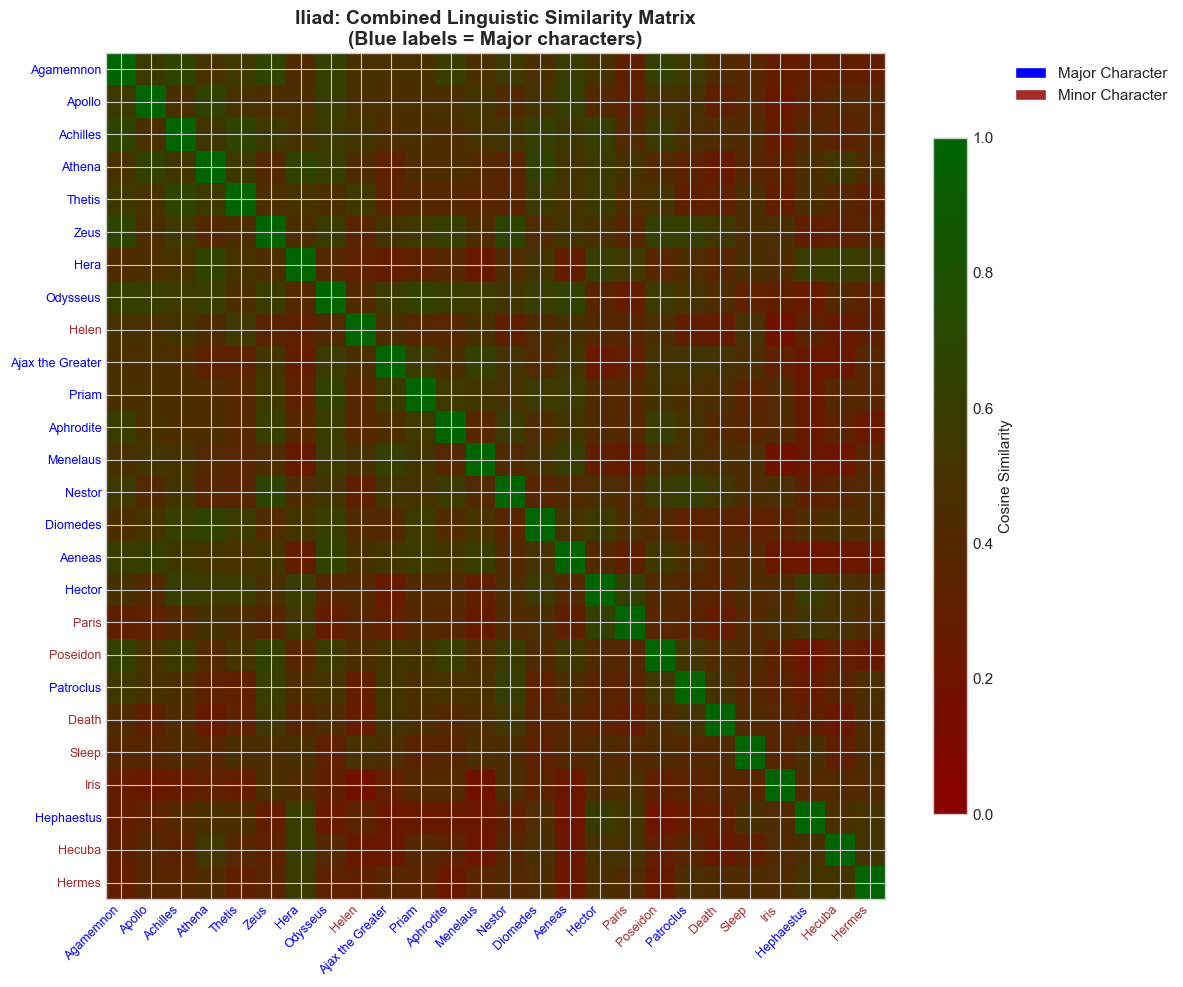

✓ Saved: ..\results\figures\odyssey_similarity_heatmap.png


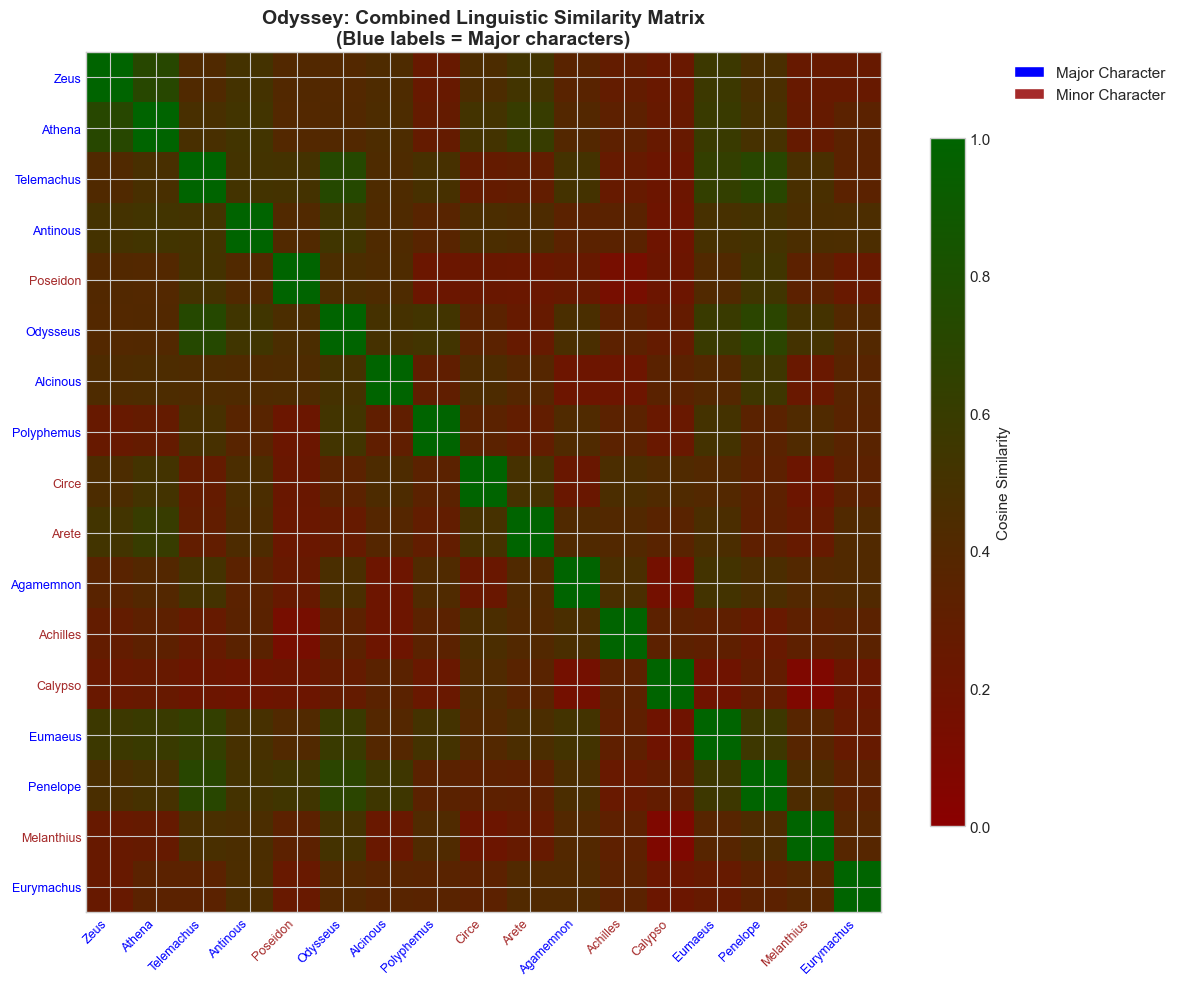

In [14]:
# ============================================================================
# VISUALIZATION: SIMILARITY HEATMAPS
# ============================================================================
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch

def plot_similarity_heatmap(sim_matrix: np.ndarray, characters: List[str], 
                            char_info: Dict, title: str, save_path: Path = None):
    """Plot a similarity heatmap with character labels colored by category."""
    
    fig, ax = plt.subplots(figsize=(12, 10))

    dark_red = "#8B0000"   # dark red
    dark_green = "#006400" # dark green

    dark_red_green_cmap = LinearSegmentedColormap.from_list("dark_red_green", [dark_red, dark_green])
    
    # Create heatmap
    im = ax.imshow(sim_matrix, cmap=dark_red_green_cmap, aspect='auto', vmin=0, vmax=1)
    
    # Set labels
    ax.set_xticks(range(len(characters)))

    ax.set_yticks(range(len(characters)))
    ax.set_xticklabels(characters, rotation=45, ha='right', fontsize=9)
    ax.set_yticklabels(characters, fontsize=9)

    legend_elements = [
        Patch(facecolor='blue', label='Major Character'),
        Patch(facecolor='brown', label='Minor Character')
    ]
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.15, 1))

    ax.set_title(title, fontsize=14, fontweight='bold')
    
    # Color labels by category
    for i, char in enumerate(characters):
        color = 'blue' if char_info[char]['category'] == 'major' else 'brown'
        ax.get_xticklabels()[i].set_color(color)
        ax.get_yticklabels()[i].set_color(color)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Cosine Similarity', fontsize=11)
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ Saved: {save_path}")
    
    plt.show()


# Plot Iliad combined similarity heatmap
plot_similarity_heatmap(
    iliad_combined_sim,
    iliad_analyzer.characters,
    iliad_analyzer.char_info,
    "Iliad: Combined Linguistic Similarity Matrix\n(Blue labels = Major characters)",
    FIGURES_DIR / "iliad_similarity_heatmap.png"
)

# Plot Odyssey combined similarity heatmap
plot_similarity_heatmap(
    odyssey_combined_sim,
    odyssey_analyzer.characters,
    odyssey_analyzer.char_info,
    "Odyssey: Combined Linguistic Similarity Matrix\n(Blue labels = Major characters)",
    FIGURES_DIR / "odyssey_similarity_heatmap.png"
)


### 6.2 Hierarchical Clustering Dendrograms

Dendrograms show hierarchical clustering of characters based on linguistic similarity.


✓ Saved: ..\results\figures\iliad_dendrogram.png


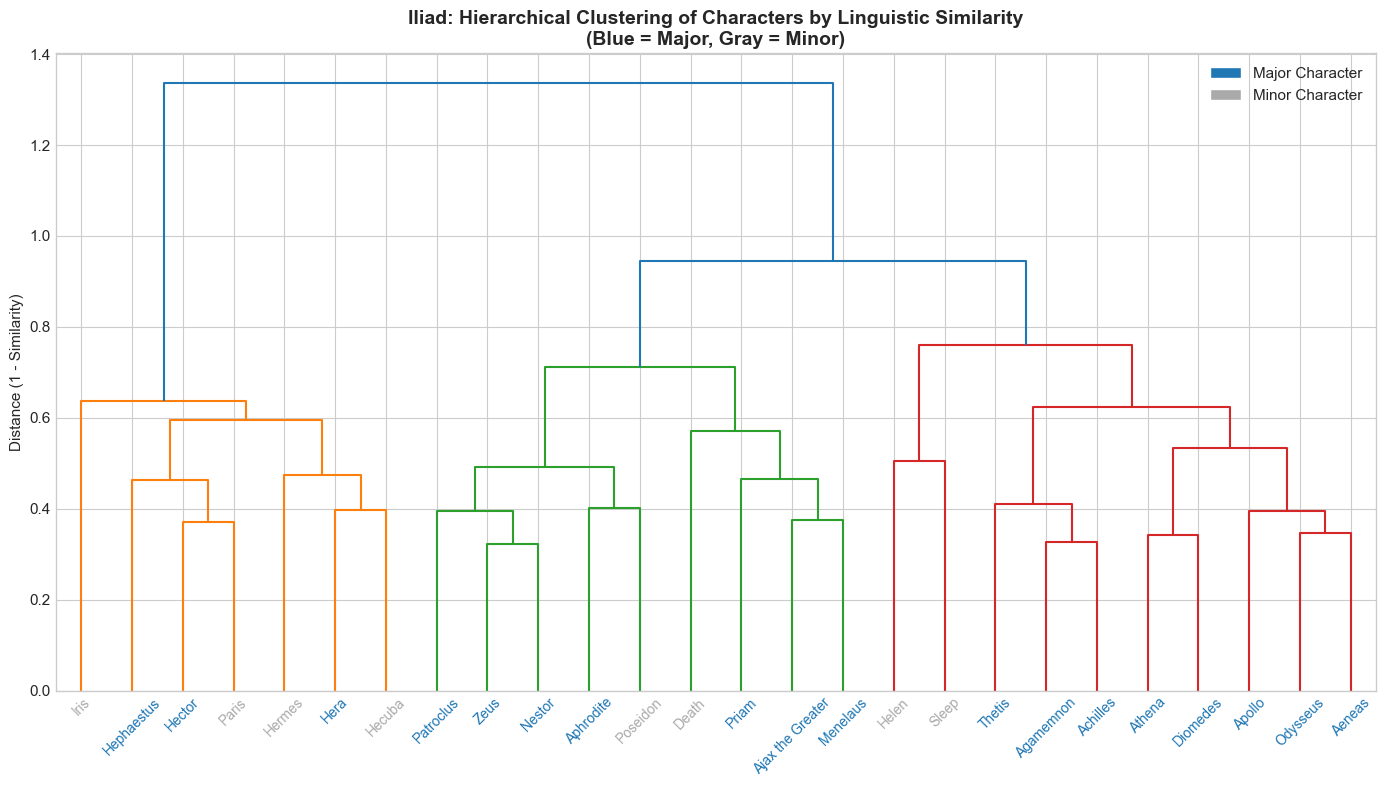

✓ Saved: ..\results\figures\odyssey_dendrogram.png


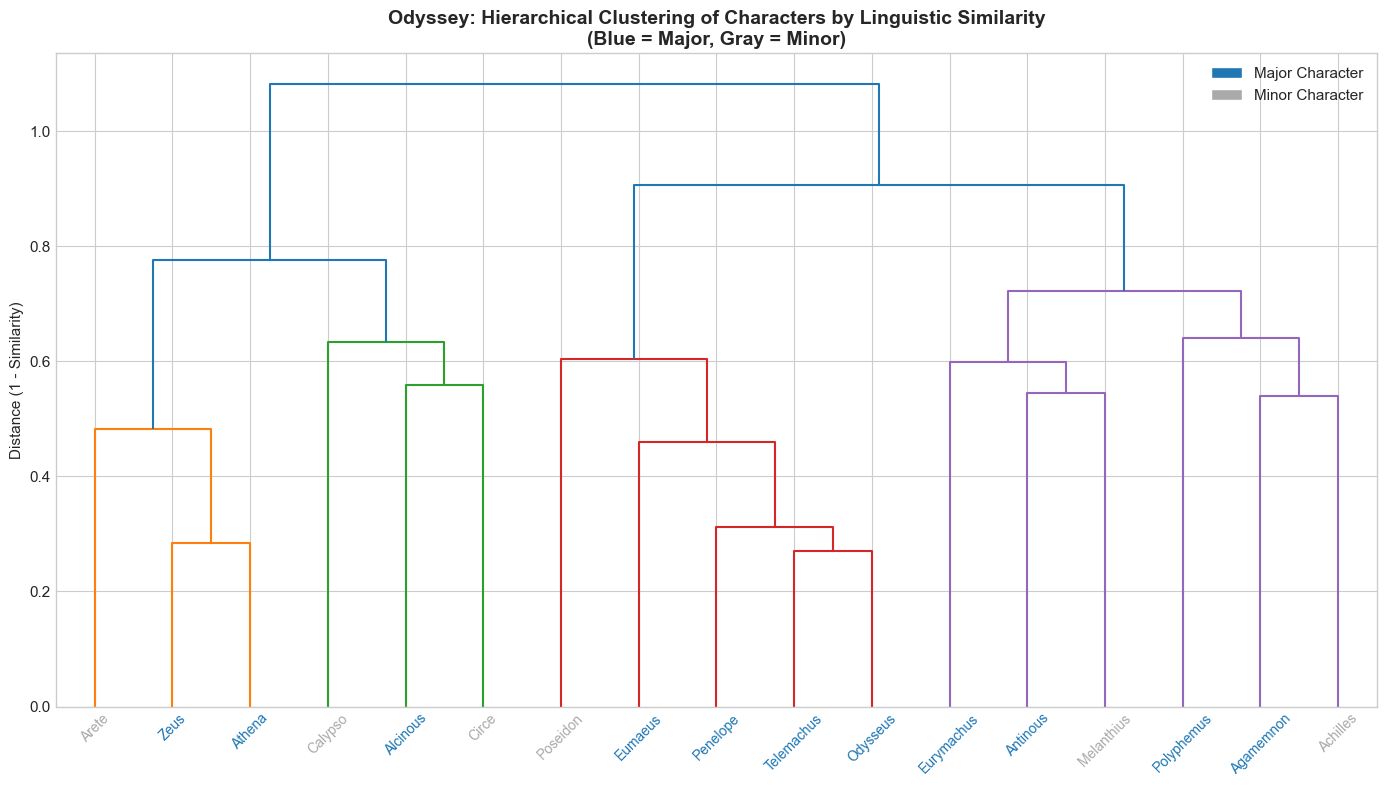

In [15]:
# ============================================================================
# VISUALIZATION: HIERARCHICAL CLUSTERING DENDROGRAMS
# ============================================================================
from matplotlib.patches import Patch

def plot_dendrogram(sim_matrix: np.ndarray, characters: List[str], char_info: Dict,
                    title: str, save_path: Path = None):
    """Plot hierarchical clustering dendrogram."""
    
    # Convert similarity to distance
    distance_matrix = 1 - sim_matrix
    np.fill_diagonal(distance_matrix, 0)
    
    # Ensure matrix is symmetric (fix floating point precision issues)
    distance_matrix = (distance_matrix + distance_matrix.T) / 2
    
    # Compute linkage
    condensed_dist = squareform(distance_matrix)
    Z = linkage(condensed_dist, method='ward')
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Color function based on category
    def get_leaf_color(char):
        return '#1f77b4' if char_info[char]['category'] == 'major' else '#aaaaaa'

    legend_elements = [
        Patch(facecolor='#1f77b4', label='Major Character'),
        Patch(facecolor='#aaaaaa', label='Minor Character')
    ]
    ax.legend(handles=legend_elements, loc='upper right')

    ax.set_title(title, fontsize=14, fontweight='bold')
    
    # Plot dendrogram
    dn = dendrogram(
        Z,
        labels=characters,
        ax=ax,
        leaf_rotation=45,
        leaf_font_size=10
    )
    
    # Color the labels
    xlbls = ax.get_xticklabels()
    for lbl in xlbls:
        char = lbl.get_text()
        if char in char_info:
            lbl.set_color(get_leaf_color(char))
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel('Distance (1 - Similarity)', fontsize=11)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ Saved: {save_path}")
    
    plt.show()


# Plot dendrograms for both epics
plot_dendrogram(
    iliad_combined_sim,
    iliad_analyzer.characters,
    iliad_analyzer.char_info,
    "Iliad: Hierarchical Clustering of Characters by Linguistic Similarity\n(Blue = Major, Gray = Minor)",
    FIGURES_DIR / "iliad_dendrogram.png"
)

plot_dendrogram(
    odyssey_combined_sim,
    odyssey_analyzer.characters,
    odyssey_analyzer.char_info,
    "Odyssey: Hierarchical Clustering of Characters by Linguistic Similarity\n(Blue = Major, Gray = Minor)",
    FIGURES_DIR / "odyssey_dendrogram.png"
)


### 6.3 Dimensionality Reduction Plots (PCA)

We use PCA to project character embeddings into 2D space for visualization, coloring by category and role.


✓ Saved: ..\results\figures\iliad_pca_category.png


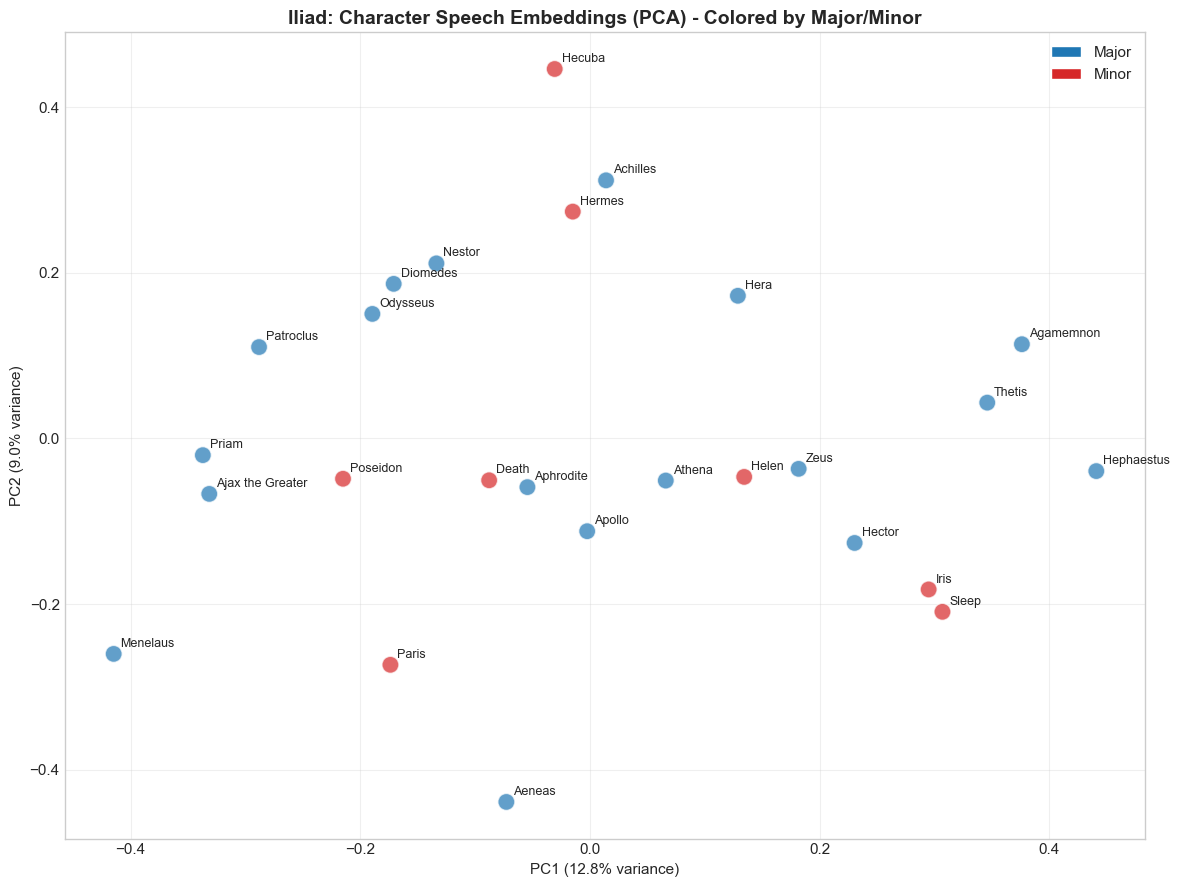

✓ Saved: ..\results\figures\iliad_pca_role.png


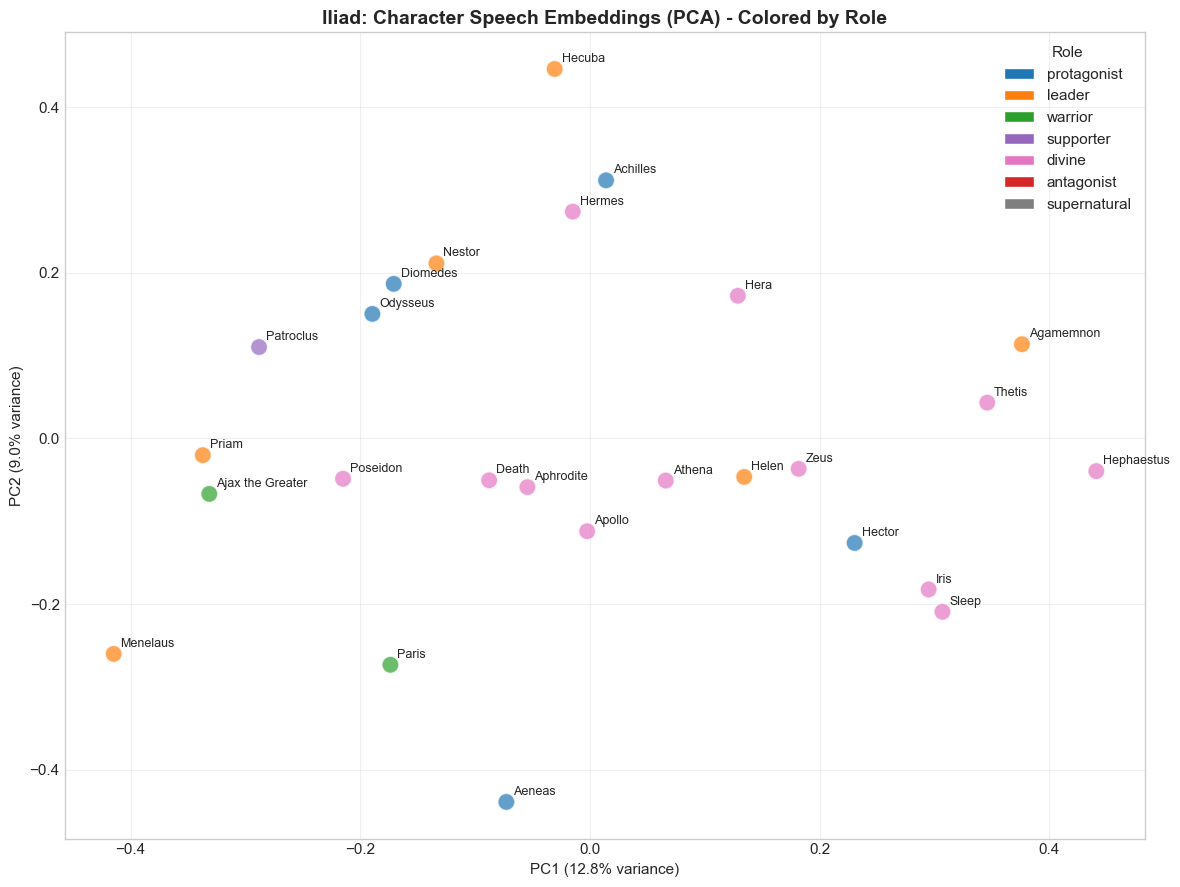

✓ Saved: ..\results\figures\odyssey_pca_category.png


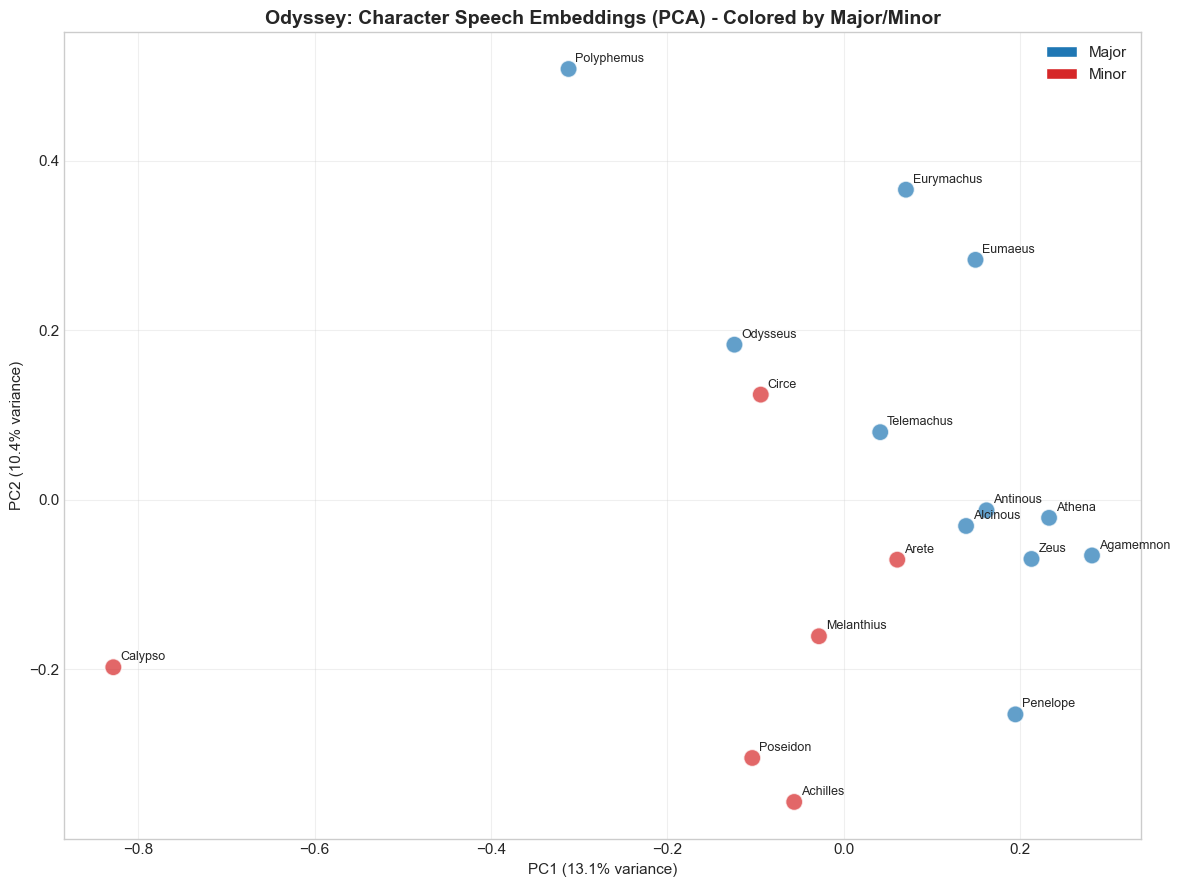

✓ Saved: ..\results\figures\odyssey_pca_role.png


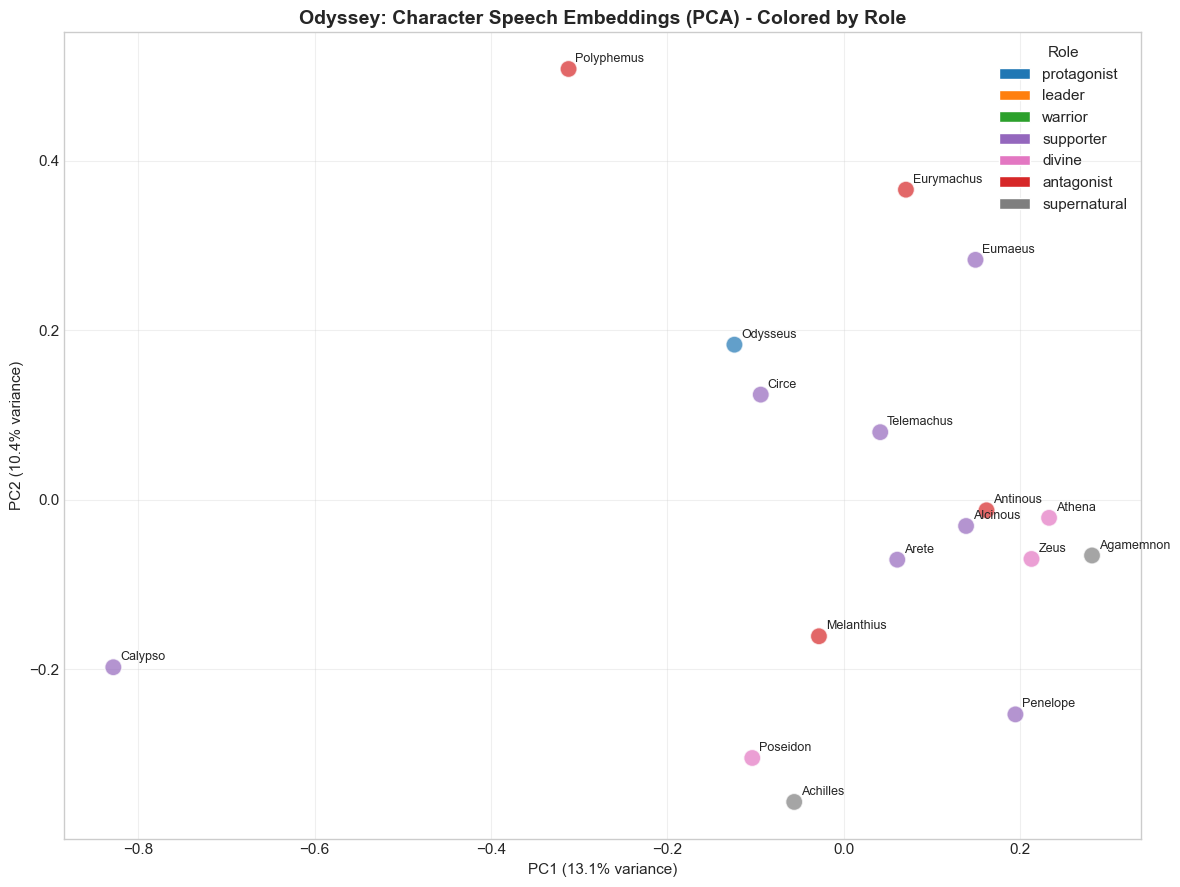

In [16]:
# ============================================================================
# VISUALIZATION: PCA EMBEDDING PLOTS
# ============================================================================

def plot_pca_embeddings(embeddings: Dict[str, np.ndarray], char_info: Dict,
                        title: str, color_by: str = 'category', save_path: Path = None):
    """Plot PCA projection of character embeddings."""
    
    characters = list(embeddings.keys())
    emb_matrix = np.array([embeddings[c] for c in characters])
    
    # Apply PCA
    pca = PCA(n_components=2)
    coords = pca.fit_transform(emb_matrix)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 9))
    
    # Color mapping
    if color_by == 'category':
        colors = ['#1f77b4' if char_info[c]['category'] == 'major' else '#d62728' 
                  for c in characters]
        legend_labels = {'#1f77b4': 'Major', '#d62728': 'Minor'}
    else:  # color by role
        role_colors = {
            'protagonist': '#1f77b4',
            'leader': '#ff7f0e',
            'warrior': '#2ca02c',
            'supporter': '#9467bd',
            'divine': '#e377c2',
            'antagonist': '#d62728',
            'supernatural': '#7f7f7f',
        }
        colors = [role_colors.get(char_info[c]['role_category'], '#333333') for c in characters]
        legend_labels = role_colors
    
    # Plot points
    scatter = ax.scatter(coords[:, 0], coords[:, 1], c=colors, s=150, alpha=0.7, edgecolors='white', linewidth=1)
    
    # Add labels
    for i, char in enumerate(characters):
        ax.annotate(char, (coords[i, 0], coords[i, 1]), fontsize=9,
                   xytext=(5, 5), textcoords='offset points')
    
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=11)
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=11)
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    # Add legend
    if color_by == 'category':
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor=c, label=l) for c, l in legend_labels.items()]
        ax.legend(handles=legend_elements, loc='best')
    else:
        from matplotlib.patches import Patch
        legend_elements = [
        Patch(facecolor=color, label=role)
            for role, color in legend_labels.items()
        ]
        ax.legend(handles=legend_elements, title='Role', loc='upper right')

    
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ Saved: {save_path}")
    
    plt.show()


# Plot PCA for Iliad (by category)
plot_pca_embeddings(
    iliad_char_embeddings,
    iliad_analyzer.char_info,
    "Iliad: Character Speech Embeddings (PCA) - Colored by Major/Minor",
    color_by='category',
    save_path=FIGURES_DIR / "iliad_pca_category.png"
)

# Plot PCA for Iliad (by role)
plot_pca_embeddings(
    iliad_char_embeddings,
    iliad_analyzer.char_info,
    "Iliad: Character Speech Embeddings (PCA) - Colored by Role",
    color_by='role',
    save_path=FIGURES_DIR / "iliad_pca_role.png"
)

# Plot PCA for Odyssey (by category)
plot_pca_embeddings(
    odyssey_char_embeddings,
    odyssey_analyzer.char_info,
    "Odyssey: Character Speech Embeddings (PCA) - Colored by Major/Minor",
    color_by='category',
    save_path=FIGURES_DIR / "odyssey_pca_category.png"
)

# Plot PCA for Odyssey (by role)
plot_pca_embeddings(
    odyssey_char_embeddings,
    odyssey_analyzer.char_info,
    "Odyssey: Character Speech Embeddings (PCA) - Colored by Role",
    color_by='role',
    save_path=FIGURES_DIR / "odyssey_pca_role.png"
)


### 6.4 Group Similarity Comparison

Box plots comparing within-group similarity for major vs. minor characters.


✓ Saved: ..\results\figures\iliad_group_comparison.png


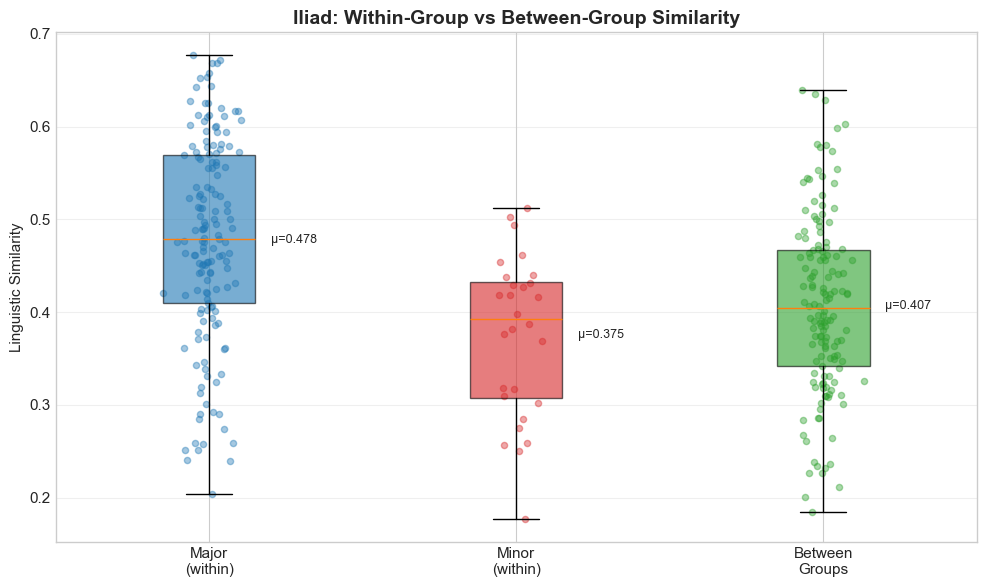

✓ Saved: ..\results\figures\odyssey_group_comparison.png


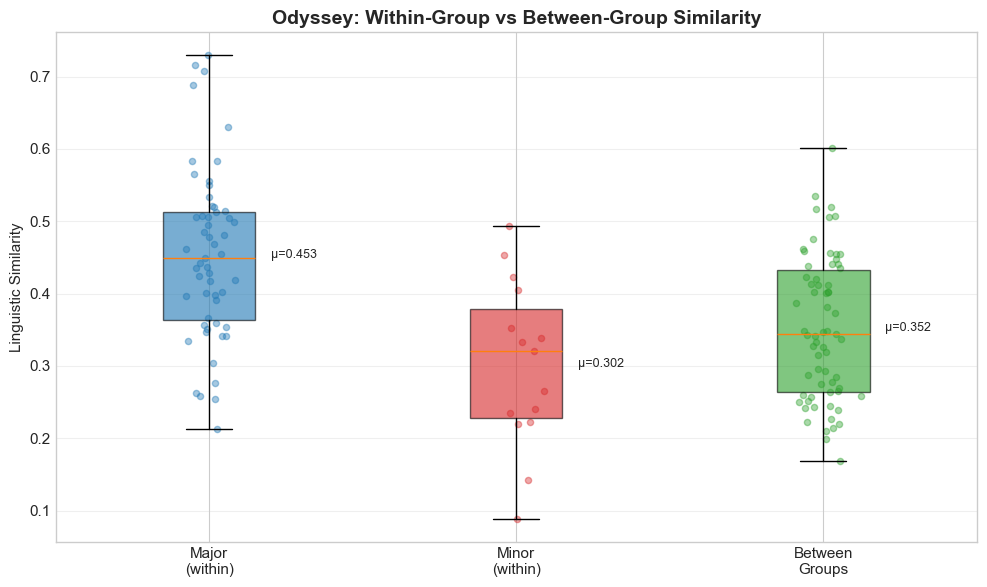

In [17]:
# ============================================================================
# VISUALIZATION: GROUP SIMILARITY COMPARISON
# ============================================================================

def plot_group_comparison(analyzer, sim_matrix, epic_name: str, save_path: Path = None):
    """Plot box plots comparing within-group similarities."""
    
    group_sims = analyzer.get_group_similarities(sim_matrix)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    data = [group_sims['major_within'], group_sims['minor_within'], group_sims['between']]
    labels = ['Major\n(within)', 'Minor\n(within)', 'Between\nGroups']
    colors = ['#1f77b4', '#d62728', '#2ca02c']
    
    bp = ax.boxplot(data, tick_labels=labels, patch_artist=True)
    
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    # Add individual points
    for i, d in enumerate(data):
        x = np.random.normal(i+1, 0.04, size=len(d))
        ax.scatter(x, d, alpha=0.4, s=20, color=colors[i])
    
    ax.set_ylabel('Linguistic Similarity', fontsize=11)
    ax.set_title(f'{epic_name}: Within-Group vs Between-Group Similarity', fontsize=14, fontweight='bold')
    ax.grid(True, axis='y', alpha=0.3)
    
    # Add mean annotations
    for i, d in enumerate(data):
        if len(d) > 0:
            mean_val = np.mean(d)
            ax.annotate(f'μ={mean_val:.3f}', xy=(i+1, mean_val), xytext=(i+1.2, mean_val),
                       fontsize=9, va='center')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ Saved: {save_path}")
    
    plt.show()


# Plot for both epics
plot_group_comparison(iliad_analyzer, iliad_combined_sim, "Iliad",
                     FIGURES_DIR / "iliad_group_comparison.png")

plot_group_comparison(odyssey_analyzer, odyssey_combined_sim, "Odyssey",
                     FIGURES_DIR / "odyssey_group_comparison.png")


---

## 7. Results Summary

We now compile all quantitative results into summary tables for export.

> **Note**: For detailed interpretation and conclusions, see `report.md`


In [18]:
# ============================================================================
# RESULTS SUMMARY - Export all findings
# ============================================================================

print("="*80)
print("FINAL RESULTS SUMMARY")
print("="*80)

# Create summary dataframe
summary_data = []

for epic, h1_result, analyzer, combined_sim in [
    ("Iliad", h1_iliad, iliad_analyzer, iliad_combined_sim),
    ("Odyssey", h1_odyssey, odyssey_analyzer, odyssey_combined_sim)
]:
    n_major = sum(1 for c in analyzer.characters if analyzer.char_info[c]['category'] == 'major')
    n_minor = sum(1 for c in analyzer.characters if analyzer.char_info[c]['category'] == 'minor')
    
    summary_data.append({
        'Epic': epic,
        'Total Characters': len(analyzer.characters),
        'Major Characters': n_major,
        'Minor Characters': n_minor,
        'Major Within-Group Similarity': h1_result['major_within_mean'],
        'Minor Within-Group Similarity': h1_result['minor_within_mean'],
        'Between-Group Similarity': h1_result['between_mean'],
        'H1 p-value': h1_result.get('p_value', np.nan),
        'H1 Supported': h1_result.get('significant', 'N/A')
    })

summary_df = pd.DataFrame(summary_data)
print("\nQuantitative Summary:")
print(summary_df.to_string(index=False))

# Save summary table
summary_df.to_csv(TABLES_DIR / "analysis_summary.csv", index=False)
print(f"\n✓ Summary saved to {TABLES_DIR / 'analysis_summary.csv'}")

# Brief results output
print("\n" + "="*80)
print("KEY METRICS")
print("="*80)

for epic, h1_result in [("Iliad", h1_iliad), ("Odyssey", h1_odyssey)]:
    print(f"\n{epic}:")
    print(f"  Major within-group similarity: {h1_result['major_within_mean']:.4f}")
    print(f"  Minor within-group similarity: {h1_result['minor_within_mean']:.4f}")
    print(f"  Between-group similarity: {h1_result['between_mean']:.4f}")
    if h1_result.get('p_value') is not None and not np.isnan(h1_result.get('p_value', np.nan)):
        print(f"  H1 test p-value: {h1_result['p_value']:.4f}")
        print(f"  H1 supported (p<0.05): {h1_result.get('significant', 'N/A')}")

print("\n" + "="*80)
print("✓ Analysis complete. See report.md for detailed interpretation.")
print("="*80)


FINAL RESULTS SUMMARY

Quantitative Summary:
   Epic  Total Characters  Major Characters  Minor Characters  Major Within-Group Similarity  Minor Within-Group Similarity  Between-Group Similarity  H1 p-value  H1 Supported
  Iliad                26                18                 8                       0.478057                       0.375072                  0.406976    0.000003          True
Odyssey                17                11                 6                       0.453190                       0.302115                  0.351924    0.000056          True

✓ Summary saved to ..\results\tables\analysis_summary.csv

KEY METRICS

Iliad:
  Major within-group similarity: 0.4781
  Minor within-group similarity: 0.3751
  Between-group similarity: 0.4070
  H1 test p-value: 0.0000
  H1 supported (p<0.05): True

Odyssey:
  Major within-group similarity: 0.4532
  Minor within-group similarity: 0.3021
  Between-group similarity: 0.3519
  H1 test p-value: 0.0001
  H1 supported (p<0.05): 

---

## Output Summary

**Figures saved to `results/figures/`:**
- `iliad_similarity_heatmap.png` - Combined similarity matrix (Iliad)
- `odyssey_similarity_heatmap.png` - Combined similarity matrix (Odyssey)
- `iliad_dendrogram.png` - Hierarchical clustering (Iliad)
- `odyssey_dendrogram.png` - Hierarchical clustering (Odyssey)
- `iliad_pca_category.png` - PCA by major/minor (Iliad)
- `iliad_pca_role.png` - PCA by narrative role (Iliad)
- `odyssey_pca_category.png` - PCA by major/minor (Odyssey)
- `odyssey_pca_role.png` - PCA by narrative role (Odyssey)
- `iliad_group_comparison.png` - Group similarity boxplots (Iliad)
- `odyssey_group_comparison.png` - Group similarity boxplots (Odyssey)

**Tables saved to `results/tables/`:**
- `iliad_character_classification.csv` - Character metadata and classification
- `odyssey_character_classification.csv` - Character metadata and classification
- `analysis_summary.csv` - Quantitative results summary

---

**For detailed interpretation and conclusions, see `report.md`**


*Analysis notebook for NLP Final Project - See `report.md` for detailed conclusions*
